# Objectif

Notre but est de pouvoir segmenter les différentes zones du cerveau au sein d'une images médicale (radio?). Ici, nous voulons différentier:
* les liquides
* la matière grise
* la matière blanche.

*Nous devons donc generer, à partir d'une image radio du cerveau, une nouvelle image possedant seulement 4 teintes de couleurs. 3 de ces teintes seront attribuées aux trois zones à segmenter, et la derniere sera utiliser pour tout ce qui n'est pas du cerveau (le fond de l'image)*

# Chargement des bibliothèques

In [2]:
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib

# Définition du chemin du dossier contenant les données d'IRM
# Remplacez ce chemin par celui qui contient vos propres données
Dossier = '/content/drive/MyDrive/donnee_IMMI'

os.chdir(Dossier)

#### Affichage rapide des images :

La fonction fast_display permet d'afficher plusieurs images 2D en une seule figure, ce qui est utile pour comparer visuellement différentes coupes d'une image 3D.

#### Visualisation des coupes médianes :

La fonction printSlices affiche trois coupes médianes d'une image 3D (axiale, coronale, sagittale). Cela aide à examiner les caractéristiques internes de l'image à partir de différents plans.

In [4]:
# Fonction pour afficher rapidement une liste d'images en 2D
def fast_display(*imd2dlist):
    plt.figure(figsize=(16,8))
    nbimg = len(imd2dlist)
    cols = min(9, nbimg)
    rows = (nbimg // cols) + 1
    for ii, img2d in enumerate(imd2dlist):
        plt.subplot(rows, cols, 1 + ii)
        plt.imshow(img2d)
    plt.show()

# Fonction pour afficher les trois coupes sagittale, coronale et axiale d'une image 3D
def printSlices(img):
    sx, sy, sz, _ = img.shape
    fast_display(img[sx//2, :, :, 0], img[:, sy//2, :, 0], img[:, :, sz//2, 0])

# Chargement des données d'entrainements

NOUVEAU PATIENT :  subject-1-label.img
T1 : coupes sagittale, coronale, axiale de subject-1-label.img


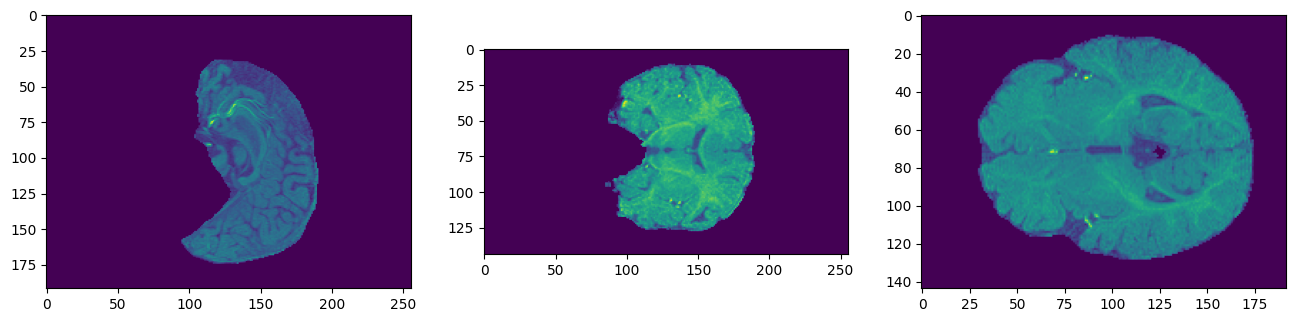

T2 : coupes sagittale, coronale, axiale de subject-1-label.img


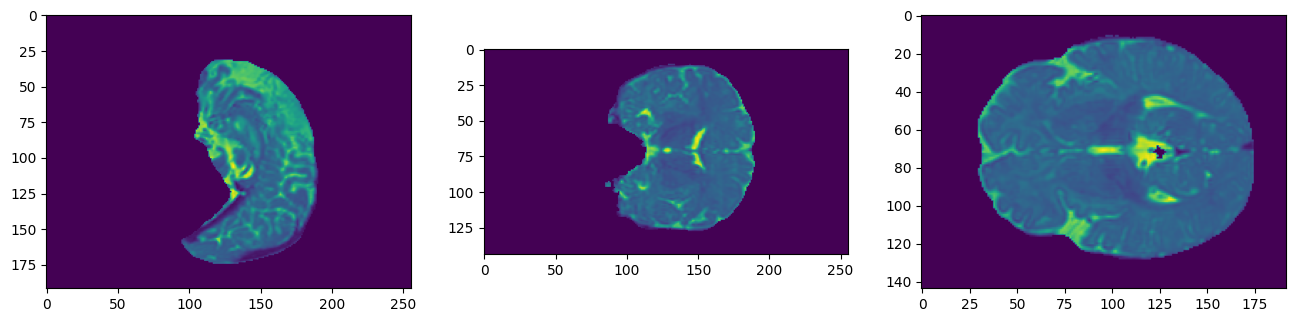

LABELS : coupes sagittale, coronale, axiale de subject-1-label.img


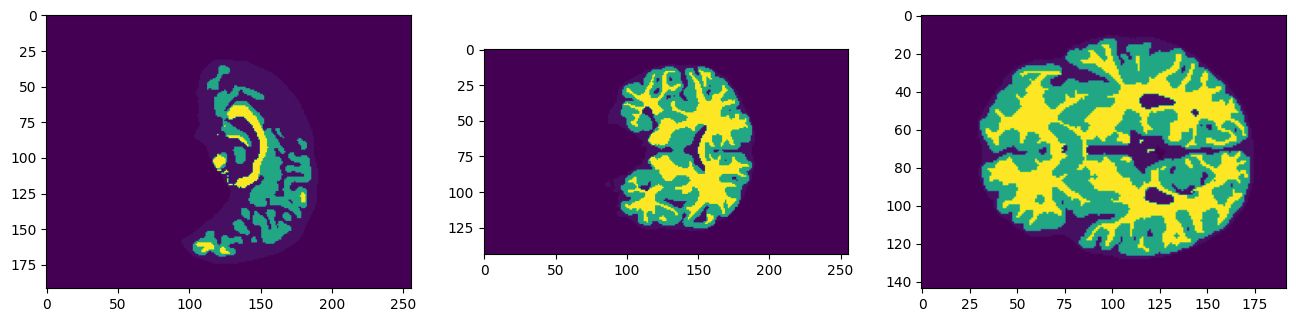

NOUVEAU PATIENT :  subject-3-label.img
NOUVEAU PATIENT :  subject-2-label.img
NOUVEAU PATIENT :  subject-4-label.img
NOUVEAU PATIENT :  subject-6-label.img
NOUVEAU PATIENT :  subject-5-label.img
NOUVEAU PATIENT :  subject-7-label.img
NOUVEAU PATIENT :  subject-8-label.img
NOUVEAU PATIENT :  subject-9-label.img
NOUVEAU PATIENT :  subject-10-label.img


In [5]:
# Variable pour compter le nombre total de patients dans les données
nb_total_patient = 0

# Parcours des fichiers dans le dossier pour charger et afficher les images T1, T2, et les labels
for dirname, _, filenames in os.walk(Dossier):
    for filename in filenames:
        # Vérification si le fichier contient des labels
        if 'label' in filename and 'hdr' not in filename:
            print("NOUVEAU PATIENT : ", filename)

            # Chargement et affichage de l'image T1
            nomT1 = filename[:-10] + "-T1.img"
            T1 = nib.load(nomT1).get_fdata()
            if nb_total_patient == 0:
                print("T1 : coupes sagittale, coronale, axiale de", filename)
                printSlices(T1)

            # Chargement et affichage de l'image T2
            nomT2 = filename[:-10] + "-T2.img"
            T2 = nib.load(nomT2).get_fdata()
            if nb_total_patient == 0:
                print("T2 : coupes sagittale, coronale, axiale de", filename)
                printSlices(T2)

            # Chargement et affichage des labels
            labels = nib.load(filename).get_fdata()
            if nb_total_patient == 0:
                print("LABELS : coupes sagittale, coronale, axiale de", filename)
                printSlices(labels)

            # Incrémentation du compteur de patients
            nb_total_patient += 1

Ce code parcourt un répertoire spécifique pour charger et visualiser les images médicales T1 et T2 ainsi que les étiquettes associées pour chaque patient. Pour chaque fichier d'étiquettes trouvé, contenant 'label' dans son nom et 'hdr' absent de son nom, il identifie un nouveau patient et charge les images correspondantes en utilisant nibabel.

Ensuite, si c'est le premier patient (compteur à zéro), le code utilise la fonction printSlices pour afficher les coupes médianes sagittale, coronale, et axiale des images T1, T2, et des étiquettes. Cela permet d'avoir un aperçu général de la structure des données et de vérifier visuellement le contenu des images et des étiquettes.

Le processus inclut l'initialisation d'un compteur pour le nombre total de patients et l'incrémentation de ce compteur pour chaque nouveau patient identifié. En résumé, ce code explore un répertoire de données médicales, identifie et charge les fichiers d'étiquettes et d'images pour chaque patient, et affiche les coupes des images du premier patient trouvé pour une vue d'ensemble rapide des données.

# Fonction de calcul de score et de normalisation

In [6]:
# Fonction de calcul de la métrique Dice pour évaluer la similarité entre deux ensembles binaires
def compute_dice(X, Y):
    Xbin = (X > 0)
    Ybin = (Y > 0)
    cardIntersec = np.sum(np.logical_and(Xbin, Ybin))
    cardX = np.sum(Xbin)
    cardY = np.sum(Ybin)

    if cardX + cardY > 0:
        dice = (2.0 * cardIntersec) / (cardX + cardY)
        return dice
    else:
        return 0

# Fonction pour normaliser une image en centrant et en réduisant
def Normalisation(img):
    mu = np.mean(img[img > 0])
    sigma = np.std(img[img > 0])
    return (img - mu) / sigma

nb_total_patient

10

Ce code contient deux fonctions principales : compute_dice et Normalisation, qui sont utilisées pour l'analyse et le traitement des images médicales.

**compute_dice** :

Cette fonction calcule le coefficient de Dice, une mesure de similarité entre deux ensembles binaires.
Elle prend en entrée deux images binaires, X et Y.
Elle binarise les images (Xbin et Ybin), calcule l'intersection des deux ensembles, et la taille de chaque ensemble.
Ensuite, elle utilise ces informations pour calculer le coefficient de Dice, qui est retourné comme résultat.

**Normalisation** :

Cette fonction normalise une image en soustrayant la moyenne (mu) et en divisant par l'écart type (sigma) des valeurs positives de l'image.
La normalisation permet de centrer et réduire les valeurs de l'image pour une analyse plus uniforme.

En résumé, ces fonctions permettent de calculer une mesure de similarité entre deux images binaires et de normaliser les images pour des analyses ultérieures.

# Séparation des patients

In [7]:
# Définition des patients pour les jeux d'entraînement, validation, et test
nb_patient_training = 6
nb_patient_validation = 2
nb_patient_test = 2

list_patient_training = [f"subject-{i}" for i in range(1, 7)]
list_patient_validation = [f"subject-{i}" for i in range(7, 9)]
list_patient_test = [f"subject-{i}" for i in range(9, 11)]

print(list_patient_training)
print(list_patient_validation)
print(list_patient_test)

['subject-1', 'subject-2', 'subject-3', 'subject-4', 'subject-5', 'subject-6']
['subject-7', 'subject-8']
['subject-9', 'subject-10']


Dans ce code on sépare les échantillons de patients en 3 groupes : le groupe d'entrainement (training), le groupe de validation, et le groupe de test.

On choisit de les répartir en 60% de training, 20% validation et 20% test.

# Décompte du nombre de slices

In [8]:
# Seuil pour déterminer les tranches pertinentes à inclure dans les ensembles de données
seuil = 100

# Comptage des tranches pertinentes pour l'entraînement et la validation
nb_slice_pertinent_training = 0
nb_slice_pertinent_validation = 0
nb_patient = 1

# Parcours des fichiers pour compter les tranches pertinentes par patient
for dirname, _, filenames in os.walk(Dossier):
    for filename in filenames:
        if 'label' in filename and 'hdr' not in filename:
            if filename[:-10] in list_patient_training:
                labels = nib.load(filename).get_fdata()
                sx, sy, sz, _ = labels.shape
                labels = np.array(labels).reshape((sx, sy, sz))

                # Comptage des tranches pertinentes pour l'entraînement
                for z in range(sz):
                    slice = labels[:, :, z]
                    if np.sum(slice >= 0) >= seuil:
                        nb_slice_pertinent_training += 1

            if filename[:-10] in list_patient_validation:
                labels = nib.load(filename).get_fdata()
                sx, sy, sz, _ = labels.shape
                labels = np.array(labels).reshape((sx, sy, sz))

                # Comptage des tranches pertinentes pour la validation
                for z in range(sz):
                    slice = labels[:, :, z]
                    if np.sum(slice >= 0) >= seuil:
                        nb_slice_pertinent_validation += 1

            nb_patient += 1
print(nb_slice_pertinent_training)
print(nb_slice_pertinent_validation)

PATIENT (training):  subject-1-label.img
PATIENT (training):  subject-3-label.img
PATIENT (training):  subject-2-label.img
PATIENT (training):  subject-4-label.img
PATIENT (training):  subject-6-label.img
PATIENT (training):  subject-5-label.img
PATIENT (validation):  subject-7-label.img
PATIENT (validation):  subject-8-label.img
1536
512


Ce code analyse les images médicales pour déterminer le nombre de coupes pertinentes dans les ensembles d'entraînement et de validation.

**Initialisation** :
On définit un seuil de pertinence et initialise des compteurs pour les coupes pertinentes dans les ensembles d'entraînement et de validation.

**Parcours des fichiers** :
Parcourt les fichiers d'étiquettes dans le répertoire spécifié.

**Identification et comptage** :
Pour chaque fichier d'étiquettes, on identifie s'il appartient à l'ensemble d'entraînement ou de validation. Puis on charge les étiquettes et vérifie chaque coupe de l'image. Ensuite on incrémente les compteurs si la coupe dépasse le seuil de pertinence.

**Affichage des résultats** :
On affiche le nombre total de coupes pertinentes pour les ensembles d'entraînement et de validation.

En résumé, ce code compte le nombre de coupes pertinentes dans les ensembles d'entraînement et de validation en parcourant et analysant les fichiers d'étiquettes.

# Preparation des données

In [9]:
# Création des tableaux pour stocker les données de formation et de validation
xtrain1 = np.zeros((nb_slice_pertinent_training, sx, sy, 2))
ytrain1 = np.zeros((nb_slice_pertinent_training, sx, sy, 1))

xvalidation1 = np.zeros((nb_slice_pertinent_validation, sx, sy, 2))
yvalidation1 = np.zeros((nb_slice_pertinent_validation, sx, sy, 1))

Ce code initialise des tableaux pour stocker les données d'entraînement et de validation des images médicales et leurs étiquettes correspondantes.
Les dimensions des tableaux sont basées sur le nombre de coupes pertinentes (nb_slice_pertinent_training et nb_slice_pertinent_validation), ainsi que sur les dimensions des images (sx, sy). Cela permet de préparer les structures de données nécessaires pour stocker et manipuler les images et les étiquettes lors de l'entraînement et de la validation du modèle.

In [10]:
# Remplissage des ensembles d'entraînement et de validation avec les images et labels correspondants
nb_slice_pertinent_training_tmp = 0
nb_slice_pertinent_validation_tmp = 0

for dirname, _, filenames in os.walk(Dossier):
    for filename in filenames:
        if 'label' in filename and 'hdr' not in filename:
            if filename[:-10] in list_patient_training:
                print("PATIENT (training):", filename)
                # Chargement et normalisation des images T1 et T2
                nomT1 = filename[:-10] + "-T1.img"
                T1 = nib.load(nomT1).get_fdata()
                nomT2 = filename[:-10] + "-T2.img"
                T2 = nib.load(nomT2).get_fdata()
                labels = nib.load(filename).get_fdata()

                sx, sy, sz, _ = labels.shape
                labels = np.array(labels).reshape((sx, sy, sz))
                T1normalise = Normalisation(T1).reshape((sx, sy, sz))
                T2normalise = Normalisation(T2).reshape((sx, sy, sz))
                LabelsClipped = np.clip(labels, 0, 1).reshape((sx, sy, sz))

                # Remplissage de l'ensemble d'entraînement
                for z in range(sz):
                    slice = labels[:, :, z]
                    if np.sum(slice >= 0) >= seuil:
                        xtrain1[nb_slice_pertinent_training_tmp, :, :, 0] = T1normalise[:, :, z]
                        xtrain1[nb_slice_pertinent_training_tmp, :, :, 1] = T2normalise[:, :, z]
                        ytrain1[nb_slice_pertinent_training_tmp, :, :, 0] = LabelsClipped[:, :, z]
                        nb_slice_pertinent_training_tmp += 1

            if filename[:-10] in list_patient_validation:
                print("PATIENT (validation):", filename)
                # Chargement et normalisation des images T1 et T2
                nomT1 = filename[:-10] + "-T1.img"
                T1 = nib.load(nomT1).get_fdata()
                nomT2 = filename[:-10] + "-T2.img"
                T2 = nib.load(nomT2).get_fdata()
                labels = nib.load(filename).get_fdata()

                sx, sy, sz, _ = labels.shape
                labels = np.array(labels).reshape((sx, sy, sz))
                T1normalise = Normalisation(T1).reshape((sx, sy, sz))
                T2normalise = Normalisation(T2).reshape((sx, sy, sz))
                VT3D = np.where(labels >= 10, 1, 0)

                # Remplissage de l'ensemble de validation
                for z in range(sz):
                    slice = labels[:, :, z]
                    if np.sum(slice >= 0) >= seuil:
                        xvalidation1[nb_slice_pertinent_validation_tmp, :, :, 0] = T1normalise[:, :, z]
                        xvalidation1[nb_slice_pertinent_validation_tmp, :, :, 1] = T2normalise[:, :, z]
                        yvalidation1[nb_slice_pertinent_validation_tmp, :, :, 0] = VT3D[:, :, z]
                        nb_slice_pertinent_validation_tmp += 1

PATIENT (training):  subject-1-label.img
PATIENT (training):  subject-3-label.img
PATIENT (training):  subject-2-label.img
PATIENT (training):  subject-4-label.img
PATIENT (training):  subject-6-label.img
PATIENT (training):  subject-5-label.img
PATIENT (validation):  subject-7-label.img
PATIENT (validation):  subject-8-label.img


Prétraitement des données : Ce code suit le processus de parcours des fichiers dans le dossier spécifié pour charger les données médicales associées à chaque patient.

Extraction des données d'imagerie : Comme dans le code précédent, nous extrayons les données T1, T2 et les données labels associées à partir des fichiers correspondants. Nous normalisons également les données T1 et T2 pour les préparer à être utilisées dans l'entraînement du modèle.

Préparation des données pour l'entraînement : Une fois que nous avons les données extraites, nous les organisons dans des tableaux (xtrain, ytrain, xvalidation, yvalidation) pour former les ensembles d'entraînement et de validation du modèle.
Dans ce processus, nous continuons à filtrer les tranches d'images pertinentes en fonction du seuil spécifié, tout en ajoutant les données correspondantes aux tableaux d'entraînement et de validation. En outre, nous adaptons le traitement des données labels pour l'ensemble de validation selon les besoins spécifiques, comme en témoigne la création de VT3D.

# Observation du codage des données

In [11]:
np.unique(labels)

array([  0.,  10., 150., 250.])

# Segmentation de la boite cranienne (etape 1)

In [12]:
import tensorflow
import skimage.io as io
import skimage.transform as trans
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from keras.optimizers import Adam

def unet(input_size = (sx, sy,2)):
  inputs = Input(input_size)
  conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
  conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
  conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
  conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
  drop4 = Dropout(0.5)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

  conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
  conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
  drop5 = Dropout(0.5)(conv5)

  up6 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
  merge6 = concatenate([drop4,up6], axis = 3)
  conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
  conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

  up7 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
  conv7 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

  up8 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
  conv8 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

  up9 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
  conv9 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
  conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
  conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

  model = Model(inputs = inputs, outputs = conv10)

  model.compile(optimizer = Adam(learning_rate = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

  model
  return model

On a choisi d'utiliser le modèle U-Net, connu pour ses bonnes performances dans notre cas d'utilisation, notamment la segmentation d'images qui est adaptée aux tâches nécessitant la capture de détails fins. Les hyperparamètres sélectionnés, tels que le taux d'apprentissage, le taux de dropout et la fonction de perte, sont essentiels pour assurer de bonnes performances et une convergence efficace lors de l'entraînement du modèle.

Pour mieux comprendre ce que c'est, je me suis appuyer sur une vidéo youtube : https://www.youtube.com/watch?v=azM57JuQpQI&ab_channel=DigitalSreeni

Learning rate : Contrôle la taille des pas effectués lors de la mise à jour des poids du réseau pendant l'entraînement.

Loss function : Détermine comment l'erreur est mesurée entre les prédictions du modèle et les valeurs réelles.

Dropout Rate : Utilisé ici à 0.5, indique que la moitié des neurones sont désactivés aléatoirement à chaque mise à jour pendant l'entraînement, pour régulariser le modèle et prévenir le surapprentissage.

Metrics : Nous utilisons 'accuracy' comme métrique pour évaluer la performance du modèle pendant l'entraînement.

In [13]:
# Initialisation et chargement du modèle
model_1 = unet(input_size=(sx, sy, 2))

# Chemin d'accès pour charger les poids du modèle
model_1.load_weights('/content/drive/MyDrive/donnee_IMMI/model_step1.hdf5')  # Changez ce chemin selon l'endroit où les poids sont stockés

On créé notre premier modele de réseau de neurones. (ou on télécharge un précedemment sauvegardé)

In [ ]:
TRAINING = True

if TRAINING:
    # Configuration du callback pour le early stopping
    earlystopping = tensorflow.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0,
        patience=3,
        verbose=1,
        mode='auto',
        restore_best_weights=True
    )
    # Entraînement du modèle
    model_1.fit(
        x=xtrain1,
        y=ytrain1,
        batch_size=7,
        epochs=15,
        verbose=1,
        callbacks=[earlystopping],
        initial_epoch=0,
        validation_data=(xvalidation1, yvalidation1)
    )
    # Chemin d'accès pour sauvegarder les poids du modèle après entraînement
    model_1.save_weights('/content/drive/MyDrive/donnee_IMMI/model_step1.hdf5')  # Changez ce chemin selon l'endroit souhaité
else:
    # Chemin d'accès pour recharger les poids du modèle sans réentraînement
    model_1.load_weights('/content/drive/MyDrive/donnee_IMMI/model_step1.hdf5')  # Assurez-vous que le chemin est correct

Epoch 1/15
220/220 [==============================] - 191s 842ms/step - loss: 0.0950 - accuracy: 0.9810 - val_loss: 0.0766 - val_accuracy: 0.9995
Epoch 2/15
220/220 [==============================] - 185s 839ms/step - loss: 0.0783 - accuracy: 0.9996 - val_loss: 0.0753 - val_accuracy: 0.9993
Epoch 3/15
220/220 [==============================] - 184s 838ms/step - loss: 0.0770 - accuracy: 0.9998 - val_loss: 0.0742 - val_accuracy: 0.9996
Epoch 4/15
220/220 [==============================] - 185s 839ms/step - loss: 0.0759 - accuracy: 0.9999 - val_loss: 0.0734 - val_accuracy: 0.9996
Epoch 5/15
220/220 [==============================] - 185s 840ms/step - loss: 0.0749 - accuracy: 0.9999 - val_loss: 0.0721 - val_accuracy: 0.9998
Epoch 6/15
220/220 [==============================] - 182s 828ms/step - loss: 0.0738 - accuracy: 1.0000 - val_loss: 0.0711 - val_accuracy: 0.9998
Epoch 7/15
220/220 [==============================] - 185s 841ms/step - loss: 0.0728 - accuracy: 1.0000 - val_loss: 0.0702 -

EarlyStopping : C'est un callback de Keras qui permet d'arrêter l'entraînement prématurément si une métrique choisie (ici, 'val_loss', c'est-à-dire la perte sur les données de validation) cesse de s'améliorer.
- monitor : Spécifie la métrique à surveiller.
- patience : Nombre d'époques à attendre avant d'arrêter l'entraînement après que l'amélioration a cessé.
- restore_best_weights : Indique de restaurer les poids du modèle à la meilleure époque enregistrée lorsqu'on arrête l'entraînement, pour éviter le surapprentissage.

model_1.fit() : Méthode pour entraîner le modèle.
- x : Données d'entrée.
- y : Étiquettes de sortie attendues.
- batch_size : Taille des mini-lots utilisée pour l'entraînement.
- epochs : Nombre d'époques d'entraînement.
- callbacks : Liste des rappels à utiliser pendant l'entraînement, dans ce cas, l'arrêt anticipé. (earlystopping)
- initial_epoch : Époque initiale.
- validation_data : Données utilisées pour évaluer les performances du modèle à la fin de chaque époque.


L'utilisation du earlystopping nous permet de ne pas avoir à faire toutes les epoques si la val_loss ne diminue plus.

PATIENT (test):  subject-9-label.img
T1,T2, Prediction, Verite terrain


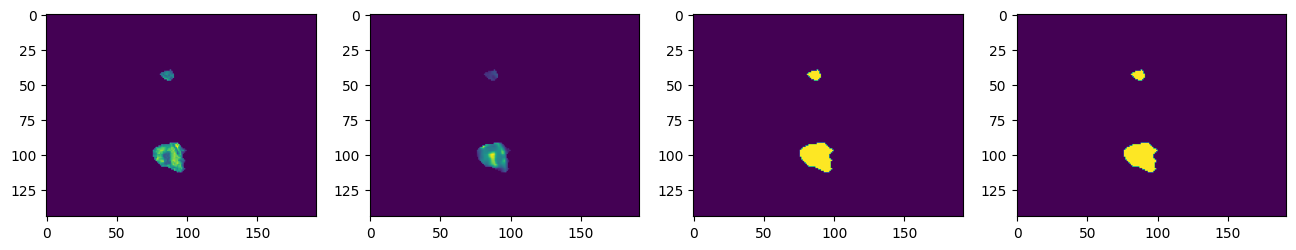

T1,T2, Prediction, Verite terrain


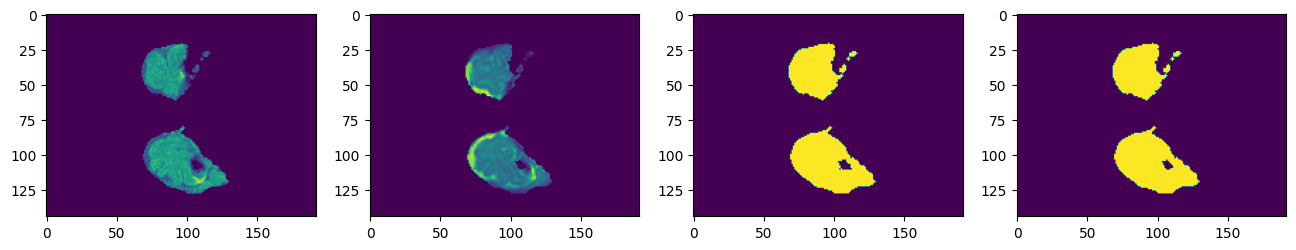

T1,T2, Prediction, Verite terrain


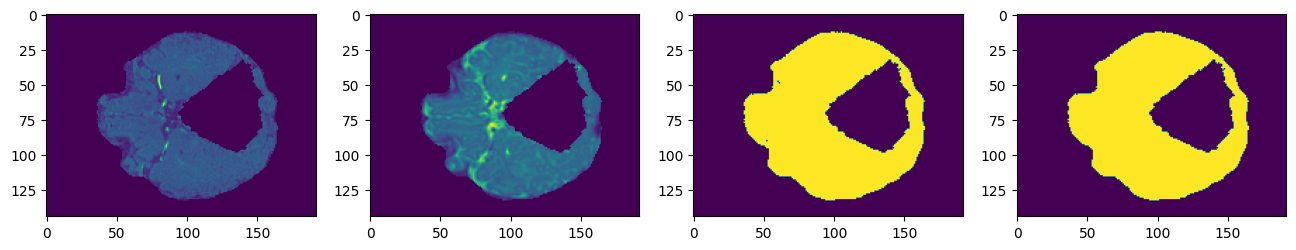

T1,T2, Prediction, Verite terrain


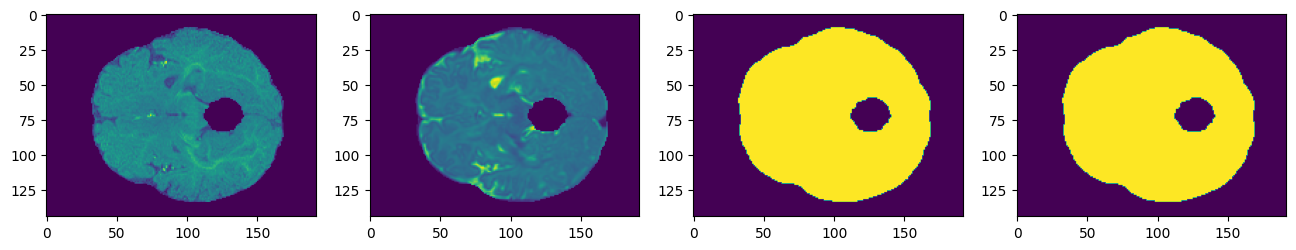

T1,T2, Prediction, Verite terrain


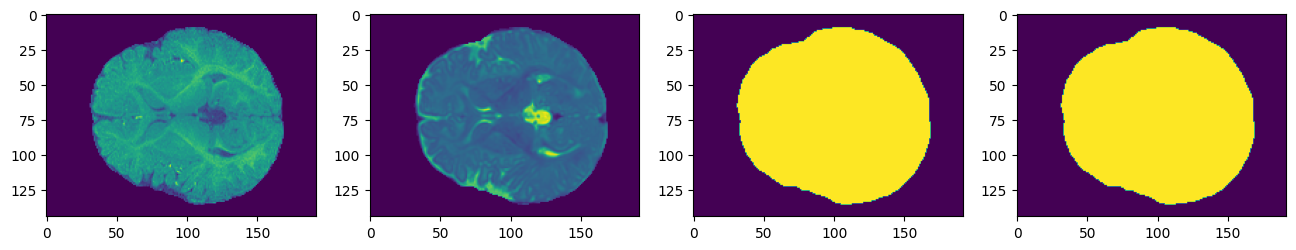

T1,T2, Prediction, Verite terrain


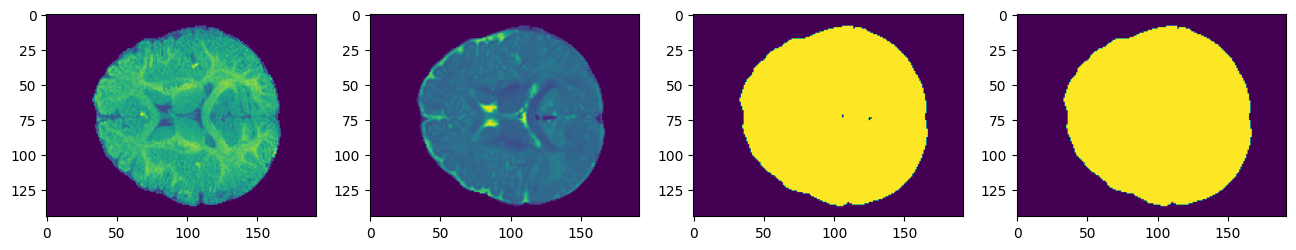

T1,T2, Prediction, Verite terrain


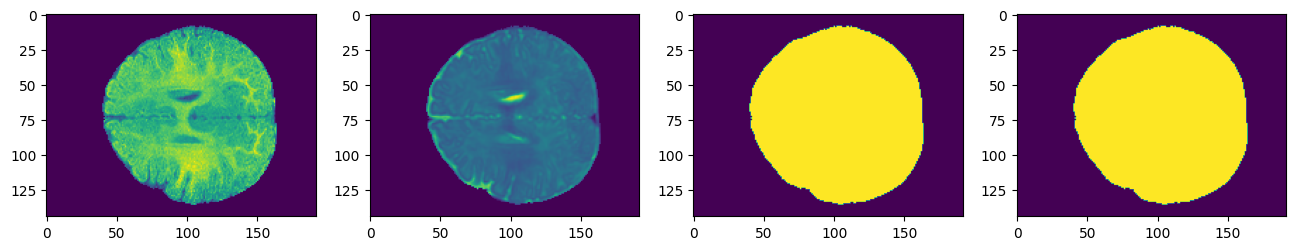

T1,T2, Prediction, Verite terrain


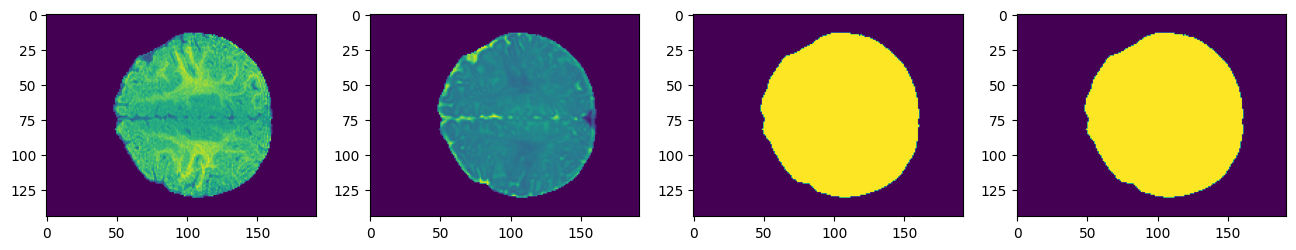

T1,T2, Prediction, Verite terrain


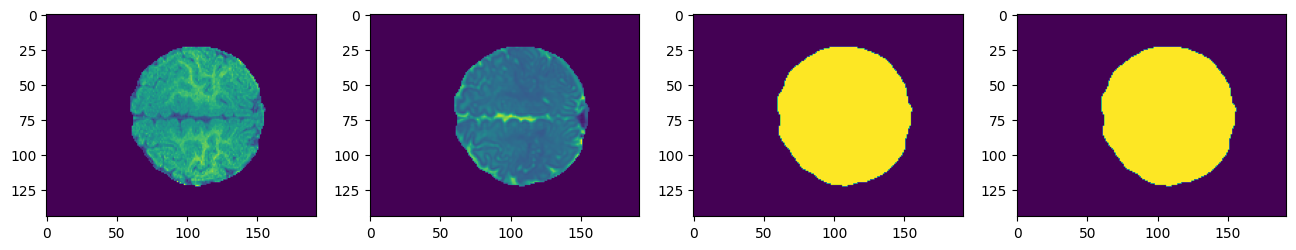

T1,T2, Prediction, Verite terrain


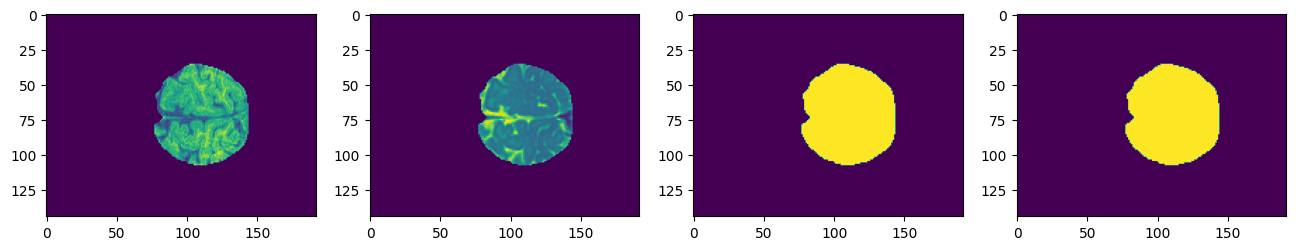

PATIENT (test):  subject-10-label.img
T1,T2, Prediction, Verite terrain


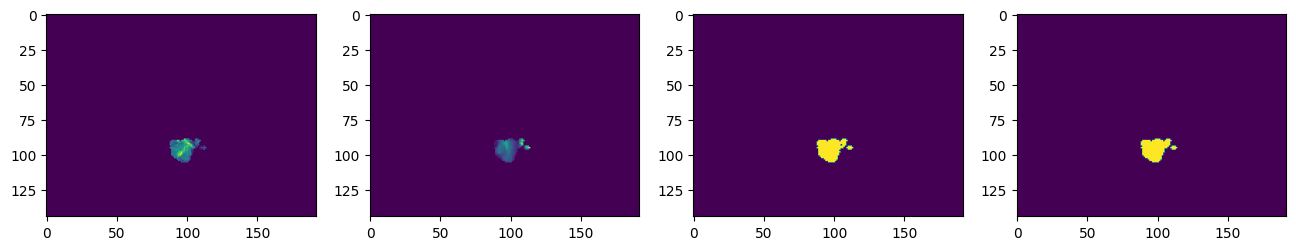

T1,T2, Prediction, Verite terrain


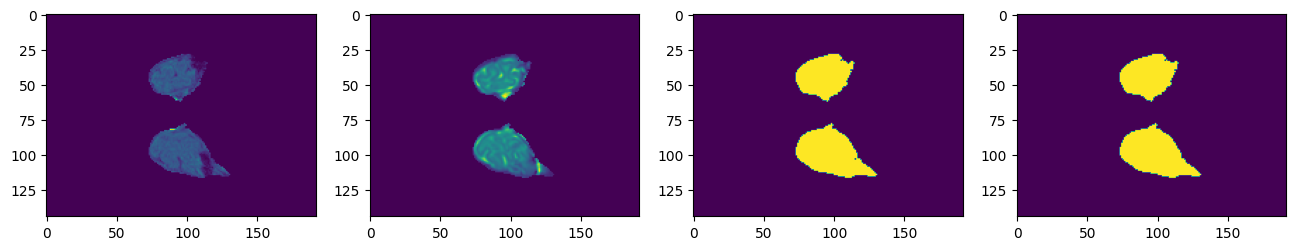

T1,T2, Prediction, Verite terrain


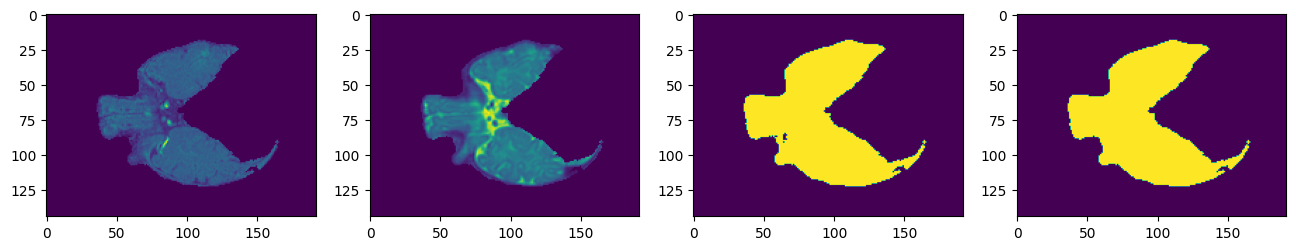

T1,T2, Prediction, Verite terrain


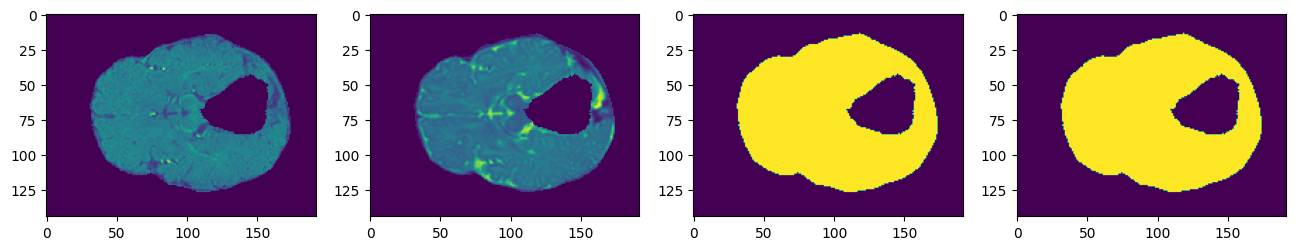

T1,T2, Prediction, Verite terrain


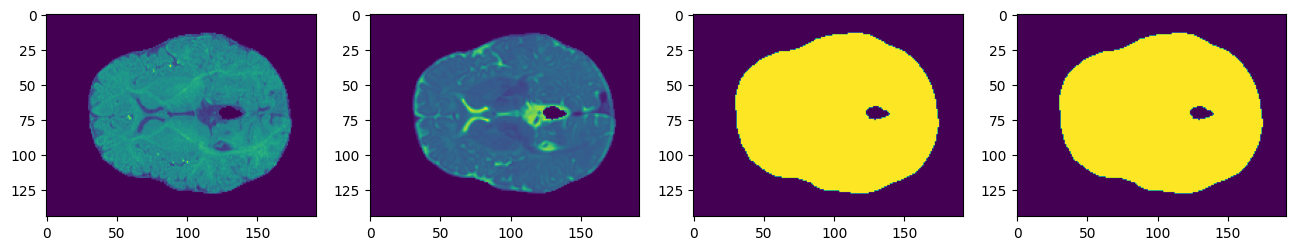

T1,T2, Prediction, Verite terrain


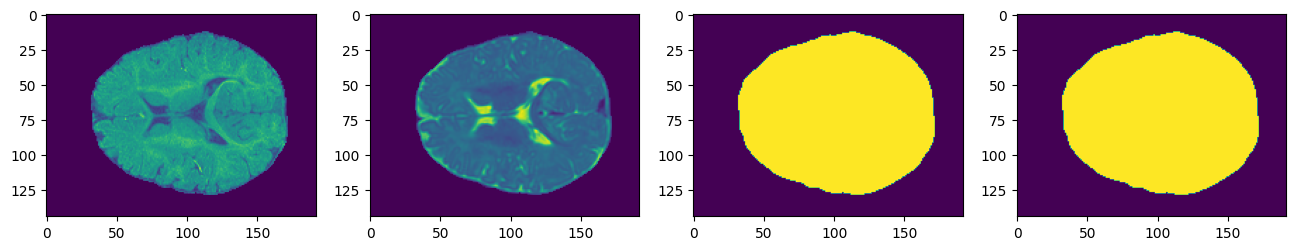

T1,T2, Prediction, Verite terrain


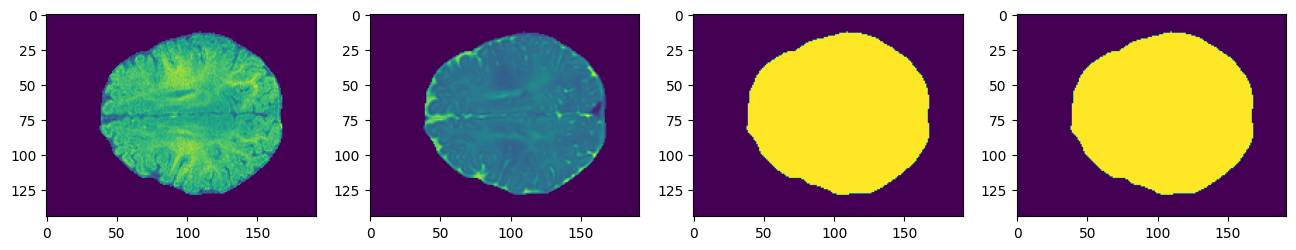

T1,T2, Prediction, Verite terrain


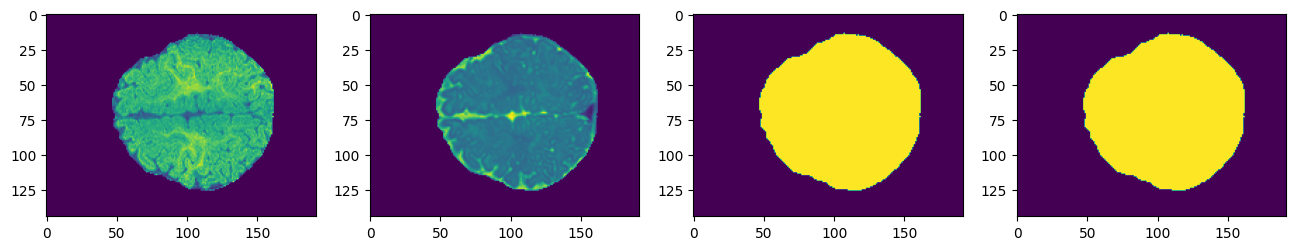

T1,T2, Prediction, Verite terrain


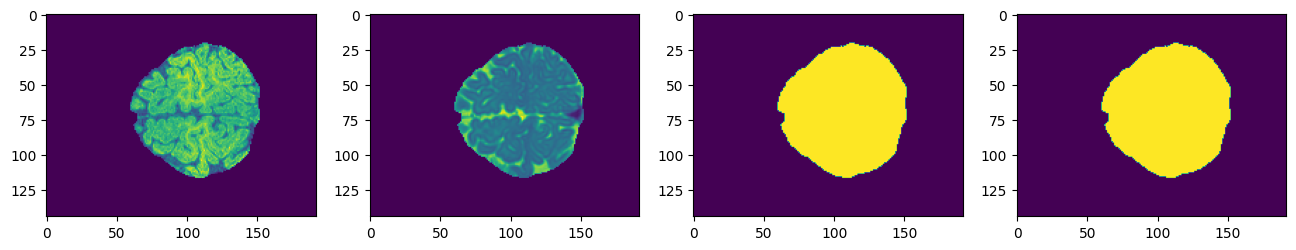

T1,T2, Prediction, Verite terrain


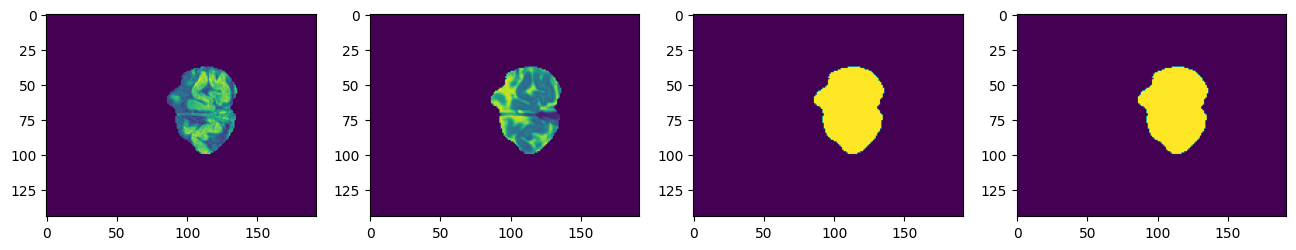

In [ ]:
liste_dices_cranes = np.zeros((nb_patient_test,))

nb_patient = 1
num_patient_test = 0

# Parcours des dossiers pour évaluer les patients de test
for dirname, _, filenames in os.walk(Dossier):  # Changez 'Dossier' pour spécifier le répertoire des données
    for filename in filenames:
        if 'label' in filename and 'hdr' not in filename:
            if filename[:-10] in list_patient_test:
                print("PATIENT (test): ", filename)
                
                # Chargement des images T1 et T2
                nomT1 = filename[:-10] + "-T1.img"
                T1 = nib.load(nomT1).get_fdata()
                nomT2 = filename[:-10] + "-T2.img"
                T2 = nib.load(nomT2).get_fdata()
                
                # Chargement des labels associés
                labels = nib.load(filename).get_fdata()
                sx, sy, sz, _ = labels.shape
                labels = np.array(labels).reshape((sx, sy, sz))

                prediction3D_10 = np.zeros((sx, sy, sz))

                T1normalise = Normalisation(T1).reshape((sx, sy, sz))
                T2normalise = Normalisation(T2).reshape((sx, sy, sz))
                VT10 = np.where(labels >= 10, 1, 0)

                for z in range(0, sz):
                    inputreseau = np.zeros((1, sx, sy, 2))
                    inputreseau[0, :, :, 0] = T1normalise[:, :, z]
                    inputreseau[0, :, :, 1] = T2normalise[:, :, z]

                    prediction10 = np.round(model_1.predict(inputreseau, verbose=0).reshape((sx, sy)))
                    prediction3D_10[:, :, z] = np.copy(prediction10)

                    if z % 10 == 0 and np.sum(VT10[:, :, z]) > 200:
                        print("T1,T2, Prediction, Verite terrain")
                        fast_display(T1normalise[:, :, z].reshape((sx, sy)), T2normalise[:, :, z].reshape((sx, sy)), prediction10.reshape((sx, sy)), VT10[:, :, z].reshape((sx, sy)))

                dice1 = compute_dice(prediction3D_10, VT10)
                liste_dices_cranes[num_patient_test] = dice1
                num_patient_test += 1
            nb_patient += 1

Dans ce code, on cherche à afficher les images T1, T2, et la vérité terrain, mais surtout la prediction.

Pour cela, on va normaliser les images T1 et T2 et récupérer uniquement les valeurs de label (VT) intéressantes. Puis on va creer un inputreseau et y mettre nos images T1 et T2, pour ainsi permettre au model_1 de faire une prediction (via '.predict').

Pour finir on va print les images en 2D afin d'avoir une vue sur la différence entre la prédiction et la vérité terrain.

On calcul aussi le dice.

In [ ]:
print(liste_dices_cranes)
print("dice unet 1 =", dice1)

[0.99982759 0.99980928]
dice unet 1 = 0.9998092792025328


On vérifie la valeur du dice afin de mieux se rendre compte de l'efficacité de notre réseau, puisque plus le coefficient est proche de 1, meilleure est la concordance entre les ensembles prédits et de référence.

# Segmentation du cerveau (etape 2)

In [14]:
# Initialisation des données d'entraînement et de validation pour un second modèle
xtrain2 = np.zeros((nb_slice_pertinent_training, sx, sy, 3))
ytrain2 = np.zeros((nb_slice_pertinent_training, sx, sy, 1))

xvalidation2 = np.zeros((nb_slice_pertinent_validation, sx, sy, 3))
yvalidation2 = np.zeros((nb_slice_pertinent_validation, sx, sy, 1))

On répète la même chose que précédemment en changeant la dimension des tableaux.

Comme pour le cas précédent, on créer le dataset, pour cela on commence de la même manière puis on rajoute les spécificité qui sont propre au 2nd modèle de réseau de neurones que l'on va implémenter.

On a changé les dimensions (+1) de xtrain et de xvalidation afin de rajouter les valeurs de VT10, et on mets les valeurs de VT150 dans ytrain et yvalidation

In [15]:
nb_slice_pertinent_training_tmp = 0
nb_slice_pertinent_validation_tmp = 0

# Extraction des images pertinentes pour l'entraînement et la validation
for dirname, _, filenames in os.walk(Dossier):  # Remplacez 'Dossier' par le chemin de vos données
    for filename in filenames:
        if 'label' in filename and 'hdr' not in filename:
            if filename[:-10] in list_patient_training:
                print("PATIENT (training): ", filename)
                nomT1 = filename[:-10] + "-T1.img"
                T1 = nib.load(nomT1).get_fdata()
                nomT2 = filename[:-10] + "-T2.img"
                T2 = nib.load(nomT2).get_fdata()
                labels = nib.load(filename).get_fdata()
                
                # Normalisation et extraction des labels
                T1normalise = Normalisation(T1).reshape((sx, sy, sz))
                T2normalise = Normalisation(T2).reshape((sx, sy, sz))
                VT10 = np.where(labels >= 10, 1, 0).reshape((sx, sy, sz))
                VT150 = np.where(labels >= 150, 1, 0).reshape((sx, sy, sz))

                for z in range(0, sz):
                    slice = labels[:, :, z]
                    if np.sum(slice >= 0) > seuil:  # Remplacez 'seuil' avec une valeur ou variable appropriée
                        xtrain2[nb_slice_pertinent_training_tmp, :, :, 0] = T1normalise[:, :, z]
                        xtrain2[nb_slice_pertinent_training_tmp, :, :, 1] = T2normalise[:, :, z]
                        xtrain2[nb_slice_pertinent_training_tmp, :, :, 2] = VT10[:, :, z]
                        ytrain2[nb_slice_pertinent_training_tmp, :, :, 0] = VT150[:, :, z]
                        nb_slice_pertinent_training_tmp += 1

            if filename[:-10] in list_patient_validation:
                print("PATIENT (validation): ", filename)
                # Même processus que pour l'entraînement
                nomT1 = filename[:-10] + "-T1.img"
                T1 = nib.load(nomT1).get_fdata()
                nomT2 = filename[:-10] + "-T2.img"
                T2 = nib.load(nomT2).get_fdata()
                labels = nib.load(filename).get_fdata()

                # Normalisation et extraction des labels
                T1normalise = Normalisation(T1).reshape((sx, sy, sz))
                T2normalise = Normalisation(T2).reshape((sx, sy, sz))
                VT10 = np.where(labels >= 10, 1, 0).reshape((sx, sy, sz))
                VT150 = np.where(labels >= 150, 1, 0).reshape((sx, sy, sz))

                for z in range(0, sz):
                    slice = labels[:, :, z]
                    if np.sum(slice >= 0) > seuil:  # Remplacez 'seuil' avec une valeur ou variable appropriée
                        xvalidation2[nb_slice_pertinent_validation_tmp, :, :, 0] = T1normalise[:, :, z]
                        xvalidation2[nb_slice_pertinent_validation_tmp, :, :, 1] = T2normalise[:, :, z]
                        xvalidation2[nb_slice_pertinent_validation_tmp, :, :, 2] = VT10[:, :, z]
                        yvalidation2[nb_slice_pertinent_validation_tmp, :, :, 0] = VT150[:, :, z]
                        nb_slice_pertinent_validation_tmp += 1

            nb_patient += 1

PATIENT (training):  subject-1-label.img
PATIENT (training):  subject-3-label.img
PATIENT (training):  subject-2-label.img
PATIENT (training):  subject-4-label.img
PATIENT (training):  subject-6-label.img
PATIENT (training):  subject-5-label.img
PATIENT (validation):  subject-7-label.img
PATIENT (validation):  subject-8-label.img


In [16]:
# Initialisation et chargement du modèle 2
model_2 = unet(input_size = (sx, sy, 3))

# Chemin d'accès pour charger les poids du modèle
model_2.load_weights('/content/drive/MyDrive/donnee_IMMI/model_step2.hdf5') # Changez ce chemin selon l'endroit où les poids sont stockés

On créé le 2nd modèle de réseau de neurones avec la dimension adaptée. Puis on l'entraine.

In [ ]:
TRAINING = True
if TRAINING :
  earlystopping = tensorflow.keras.callbacks.EarlyStopping(
      monitor = 'val_loss',
      min_delta = 0,
      patience = 5,
      verbose = 1,
      mode = 'auto',
      baseline = None,
      restore_best_weights = True
  )

  model_2.fit(
      x = xtrain2,
      y = ytrain2,
      batch_size=7,
      epochs=20,
      verbose=1,
      callbacks=[earlystopping],
      initial_epoch=0,
      validation_data=(xvalidation2, yvalidation2)
    )
  model_2.save_weights('/content/drive/MyDrive/donnee_IMMI/model_step2.hdf5')
else:
  model_2.load_weights('/content/drive/MyDrive/donnee_IMMI/model_step2.hdf5')

Epoch 1/20
220/220 [==============================] - 193s 845ms/step - loss: 0.0828 - accuracy: 0.9725 - val_loss: 0.0676 - val_accuracy: 0.9908
Epoch 2/20
220/220 [==============================] - 185s 839ms/step - loss: 0.0660 - accuracy: 0.9944 - val_loss: 0.0673 - val_accuracy: 0.9914
Epoch 3/20
220/220 [==============================] - 182s 825ms/step - loss: 0.0648 - accuracy: 0.9950 - val_loss: 0.0679 - val_accuracy: 0.9914
Epoch 4/20
220/220 [==============================] - 185s 839ms/step - loss: 0.0640 - accuracy: 0.9952 - val_loss: 0.0689 - val_accuracy: 0.9908
Epoch 5/20
220/220 [==============================] - 184s 839ms/step - loss: 0.0628 - accuracy: 0.9956 - val_loss: 0.0628 - val_accuracy: 0.9952
Epoch 6/20
220/220 [==============================] - 181s 824ms/step - loss: 0.0620 - accuracy: 0.9957 - val_loss: 0.0647 - val_accuracy: 0.9931
Epoch 7/20
220/220 [==============================] - 185s 840ms/step - loss: 0.0612 - accuracy: 0.9958 - val_loss: 0.0613 -

PATIENT (test):  subject-9-label.img
T1,T2, Prediction, Verite terrain


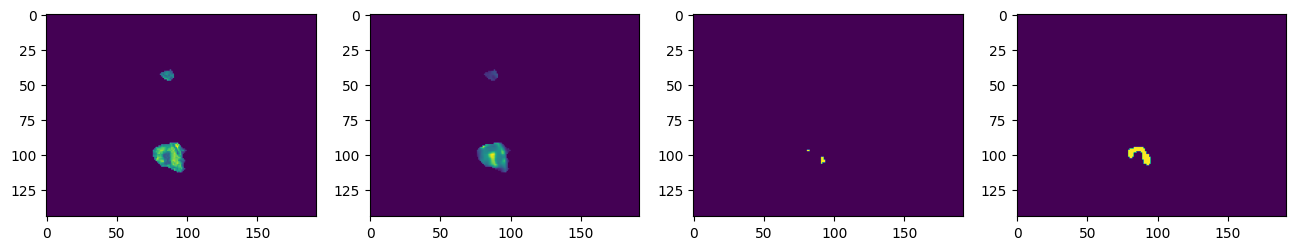

T1,T2, Prediction, Verite terrain


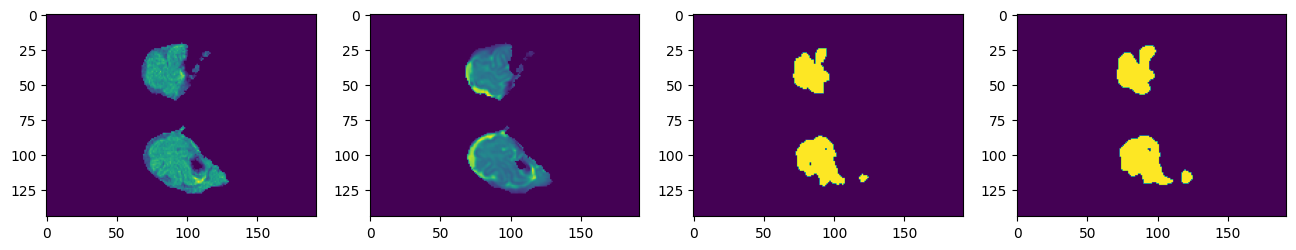

T1,T2, Prediction, Verite terrain


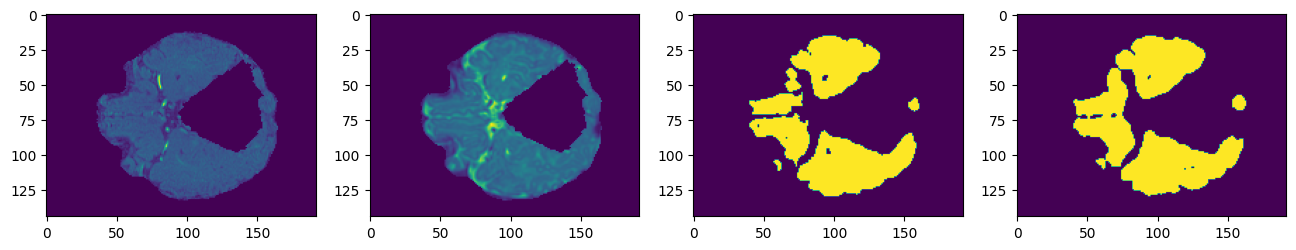

T1,T2, Prediction, Verite terrain


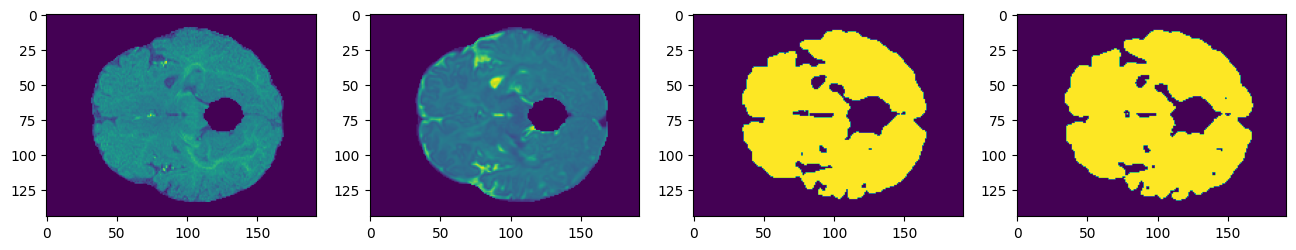

T1,T2, Prediction, Verite terrain


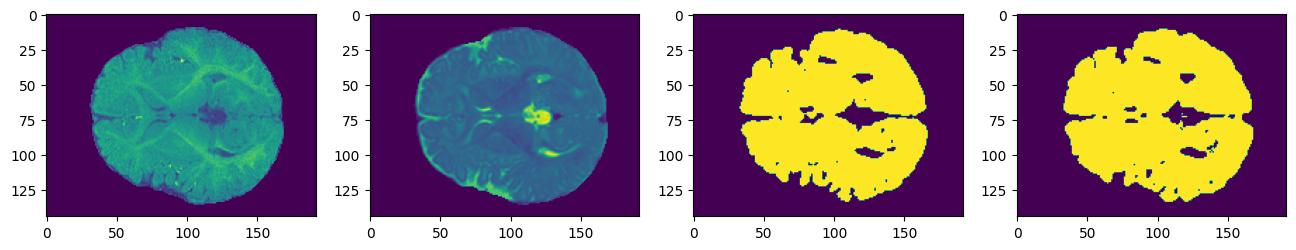

T1,T2, Prediction, Verite terrain


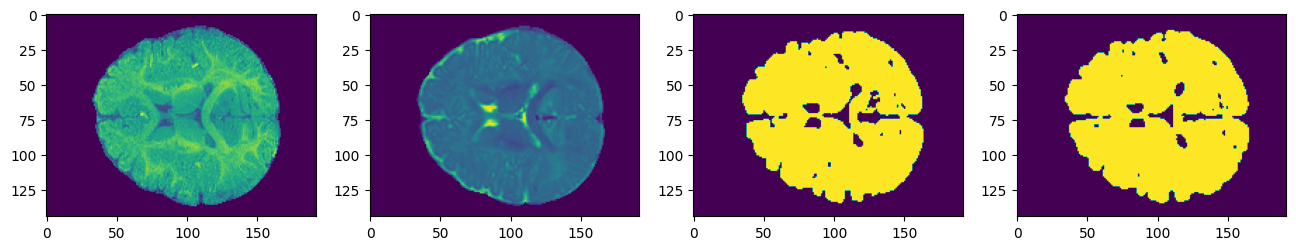

T1,T2, Prediction, Verite terrain


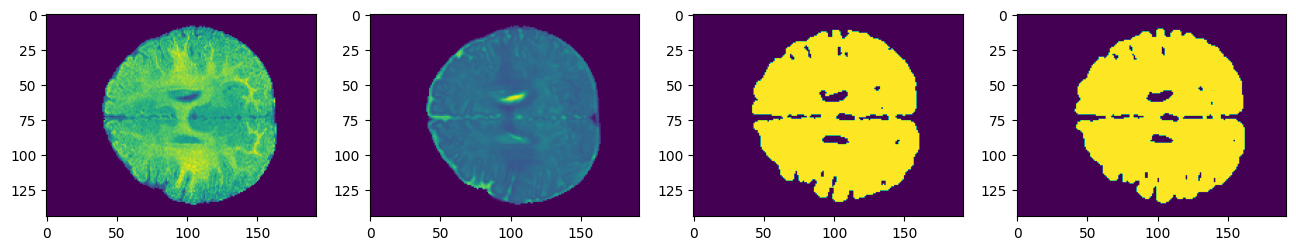

T1,T2, Prediction, Verite terrain


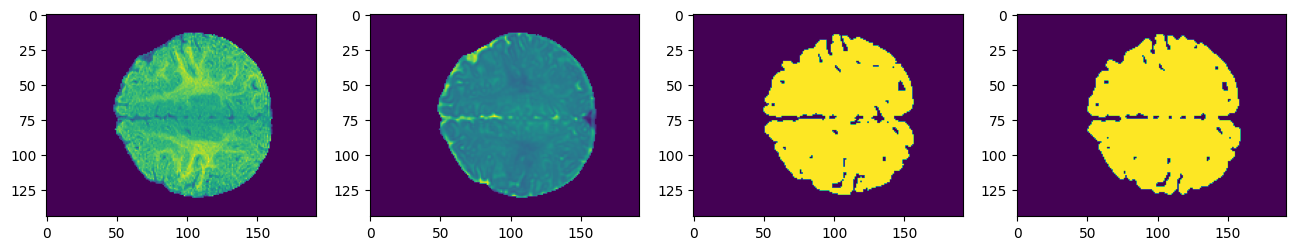

T1,T2, Prediction, Verite terrain


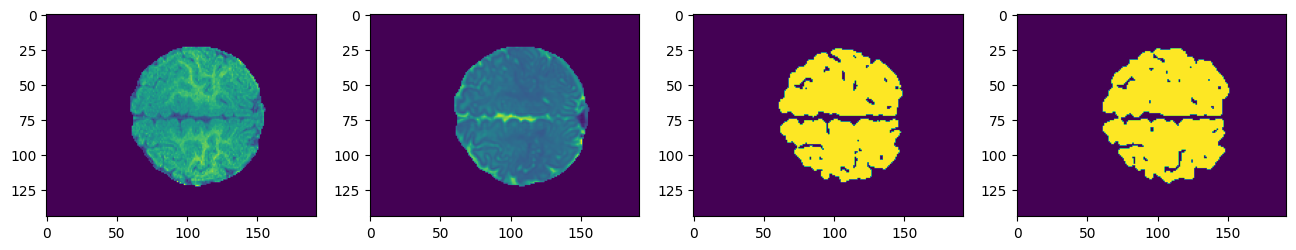

T1,T2, Prediction, Verite terrain


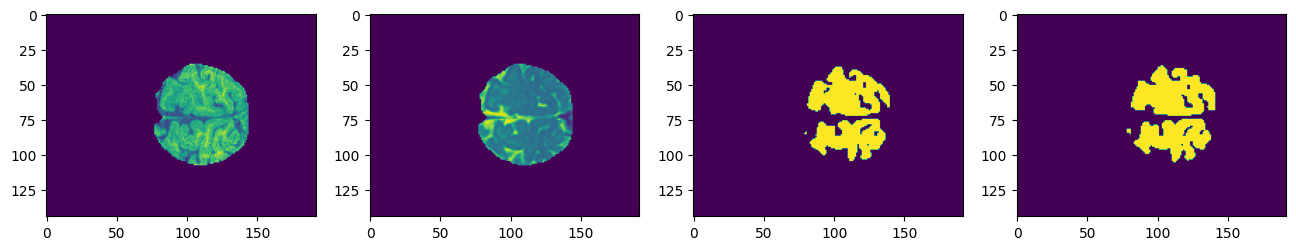

PATIENT (test):  subject-10-label.img
T1,T2, Prediction, Verite terrain


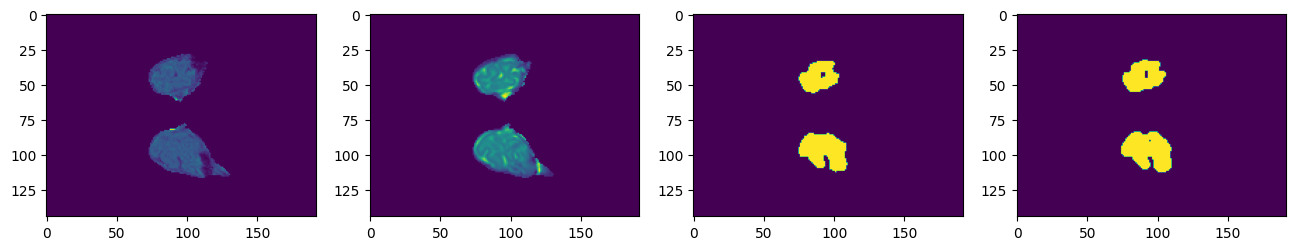

T1,T2, Prediction, Verite terrain


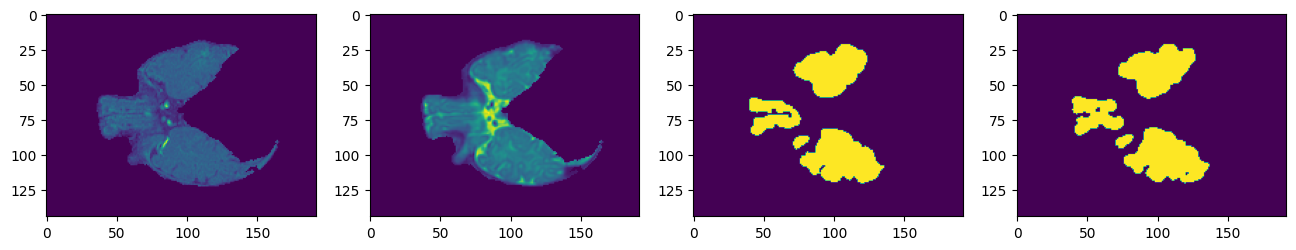

T1,T2, Prediction, Verite terrain


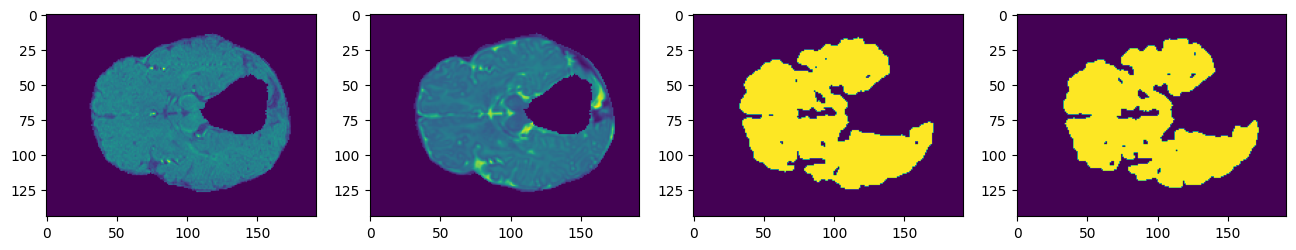

T1,T2, Prediction, Verite terrain


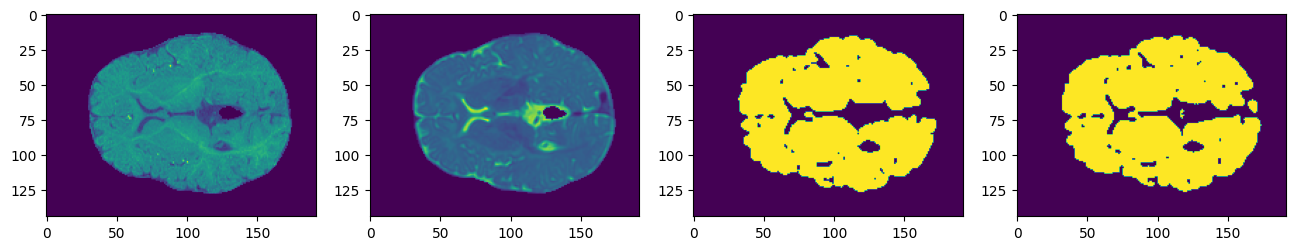

T1,T2, Prediction, Verite terrain


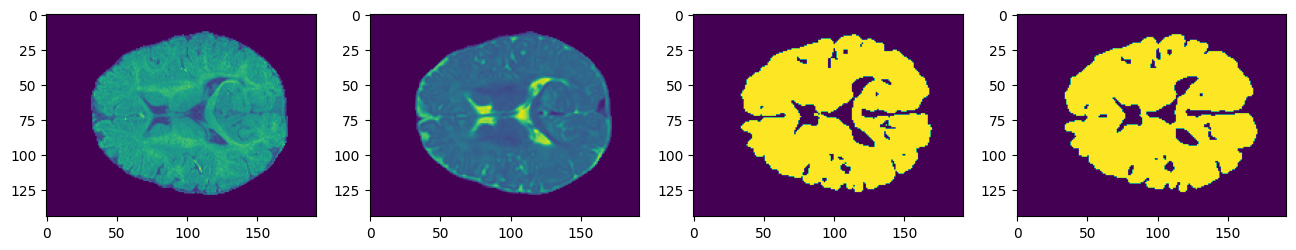

T1,T2, Prediction, Verite terrain


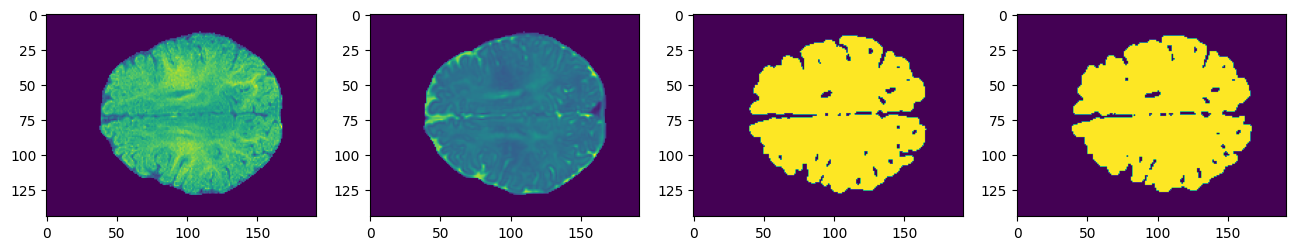

T1,T2, Prediction, Verite terrain


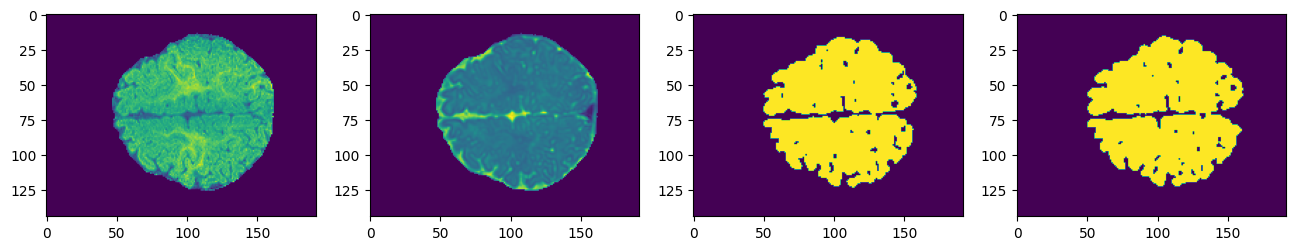

T1,T2, Prediction, Verite terrain


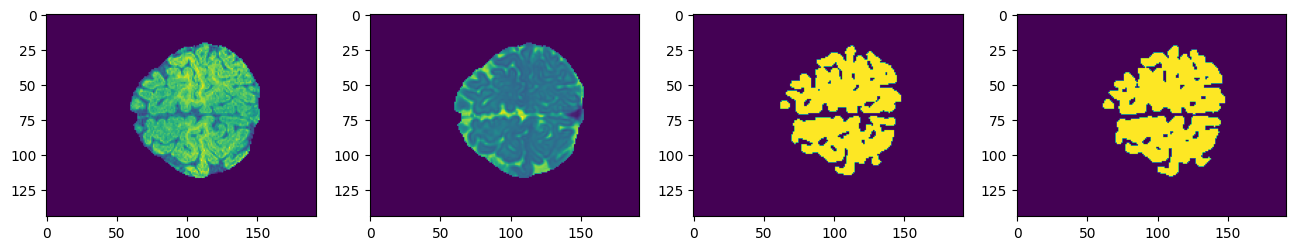

T1,T2, Prediction, Verite terrain


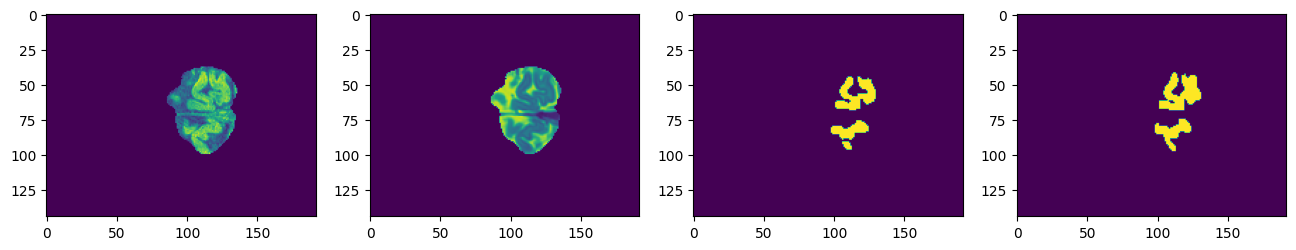

In [ ]:
liste_dices_brain = np.zeros((nb_patient_test,))

nb_patient = 1
num_patient_test = 0

for dirname, _, filenames in os.walk(Dossier):
  for filename in filenames:
    if 'label' in filename and 'hdr' not in filename:
      if filename[:-10] in list_patient_test:
        print("PATIENT (test): ", filename)
        nomT1 = filename[:-10]+"-T1.img"
        T1 = nib.load(nomT1).get_fdata()
        nomT2 = filename[:-10]+"-T2.img"
        T2 = nib.load(nomT2).get_fdata()
        labels = nib.load(filename).get_fdata()

        sx, sy, sz, _ = labels.shape
        labels = np.array(labels).reshape((sx, sy, sz))

        prediction3D_150 = np.zeros((sx, sy, sz))

        T1normalise = Normalisation(T1).reshape((sx, sy, sz))
        T2normalise = Normalisation(T2).reshape((sx, sy, sz))
        VT10 = np.where(labels >= 10,1, 0).reshape((sx,sy,sz))
        VT150 = np.where(labels >= 150,1, 0).reshape((sx,sy,sz))

        for z in range(0, sz):
          inputreseau = np.zeros((1, sx, sy, 2))
          inputreseau[0,:,:,0] = T1normalise[:,:,z]
          inputreseau[0,:,:,1] = T2normalise[:,:,z]

          prediction10 = np.round(model_1.predict(inputreseau, verbose=0).reshape((sx,sy)))

          inputreseau2 = np.zeros((1, sx, sy, 3))
          inputreseau2[0,:,:,0] = T1normalise[:,:,z]
          inputreseau2[0,:,:,1] = T2normalise[:,:,z]
          inputreseau2[0,:,:,2] = prediction10
          prediction150 = np.round(model_2.predict(inputreseau2, verbose=0).reshape((sx,sy)))

          prediction3D_150[:,:,z] = np.copy(prediction150)

          prediction_to_plot = np.copy(prediction150)
          VT_to_plot = np.copy(VT150[:,:,z])

          if z%10 == 0 and np.sum(VT_to_plot) > 0:
            VT_to_plot[0,0] = 1.0
            prediction_to_plot[0,0] = 1.0
            print("T1,T2, Prediction, Verite terrain")
            fast_display(T1normalise[:,:,z].reshape((sx,sy)), T2normalise[:,:,z].reshape((sx,sy)), prediction_to_plot[:,:].reshape((sx, sy)), VT_to_plot[:,:].reshape((sx,sy)))

        dice2 = compute_dice(prediction3D_150, VT150)
        liste_dices_brain[num_patient_test] = dice2
        num_patient_test += 1
      nb_patient += 1

De la même manière que précedemment, on cherche à afficher la prediction du second model. On procède de la même façon en rajoutant le model_2 et en faisant la prédiction.

On calcul à nouveau le dice.

In [ ]:
print(liste_dices_brain)
print("dice unet 2 =", dice2)

[0.97091629 0.9723838 ]
dice unet 2 = 0.9723838004251903


# Segmentation de la matière blanche (etape 3)

In [17]:
xtrain3 = np.zeros((nb_slice_pertinent_training, sx, sy, 4))
ytrain3 = np.zeros((nb_slice_pertinent_training, sx, sy, 1))

xvalidation3 = np.zeros((nb_slice_pertinent_validation, sx, sy, 4))
yvalidation3 = np.zeros((nb_slice_pertinent_validation, sx, sy, 1))

On créer une nouvelle fois le dataset cette fois ci pour l'étape 3.

In [18]:
nb_slice_pertinent_training_tmp = 0
nb_slice_pertinent_validation_tmp = 0

nb_patient = 1

for dirname, _, filenames in os.walk(Dossier):
  for filename in filenames:
    if 'label' in filename and 'hdr' not in filename:
      if filename[:-10] in list_patient_training:
        print("PATIENT (training): ", filename)
        nomT1 = filename[:-10]+"-T1.img"
        T1 = nib.load(nomT1).get_fdata()
        nomT2 = filename[:-10]+"-T2.img"
        T2 = nib.load(nomT2).get_fdata()
        labels = nib.load(filename).get_fdata()

        sx, sy, sz, _ = labels.shape
        labels = np.array(labels).reshape((sx, sy, sz))

        T1normalise = Normalisation(T1).reshape((sx, sy, sz))
        T2normalise = Normalisation(T2).reshape((sx, sy, sz))
        VT10 = np.where(labels >= 10, 1, 0).reshape((sx,sy,sz))
        VT150 = np.where(labels >= 150, 1, 0).reshape((sx,sy,sz))
        VT250 = np.where(labels >= 250, 1, 0).reshape((sx,sy,sz))

        for z in range(0, sz):
          slice = labels[:,:,z]
          if np.sum(slice >= 0) >- seuil:
            xtrain3[nb_slice_pertinent_training_tmp,:,:,0] = T1normalise[:,:,z]
            xtrain3[nb_slice_pertinent_training_tmp,:,:,1] = T2normalise[:,:,z]
            xtrain3[nb_slice_pertinent_training_tmp,:,:,2] = VT10[:,:,z]
            xtrain3[nb_slice_pertinent_training_tmp,:,:,3] = VT150[:,:,z]
            ytrain3[nb_slice_pertinent_training_tmp,:,:,0] = VT250[:,:,z]
            nb_slice_pertinent_training_tmp += 1

      if filename[:-10] in list_patient_validation:
        print("PATIENT (validation): ", filename)
        nomT1 = filename[:-10]+"-T1.img"
        T1 = nib.load(nomT1).get_fdata()
        nomT2 = filename[:-10]+"-T2.img"
        T2 = nib.load(nomT2).get_fdata()
        labels = nib.load(filename).get_fdata()

        sx, sy, sz, _ = labels.shape
        labels = np.array(labels).reshape((sx, sy, sz))

        T1normalise = Normalisation(T1).reshape((sx, sy, sz))
        T2normalise = Normalisation(T2).reshape((sx, sy, sz))
        VT10 = np.where(labels >= 10, 1, 0).reshape((sx,sy,sz))
        VT150 = np.where(labels >= 150, 1, 0).reshape((sx,sy,sz))
        VT250 = np.where(labels >= 250, 1, 0).reshape((sx,sy,sz))

        for z in range(0, sz):
          slice = labels[:,:,z]
          if np.sum(slice >= 0) >- seuil:
            xvalidation3[nb_slice_pertinent_validation_tmp,:,:,0] = T1normalise[:,:,z]
            xvalidation3[nb_slice_pertinent_validation_tmp,:,:,1] = T2normalise[:,:,z]
            xvalidation3[nb_slice_pertinent_validation_tmp,:,:,2] = VT10[:,:,z]
            xvalidation3[nb_slice_pertinent_validation_tmp,:,:,3] = VT150[:,:,z]
            yvalidation3[nb_slice_pertinent_validation_tmp,:,:,0] = VT250[:,:,z]
            nb_slice_pertinent_validation_tmp += 1

      nb_patient += 1

PATIENT (training):  subject-1-label.img
PATIENT (training):  subject-3-label.img
PATIENT (training):  subject-2-label.img
PATIENT (training):  subject-4-label.img
PATIENT (training):  subject-6-label.img
PATIENT (training):  subject-5-label.img
PATIENT (validation):  subject-7-label.img
PATIENT (validation):  subject-8-label.img


On a changé une nouvelle fois (+1) les dimensions de xtrain et de xvalidation afin de rajouter les valeurs de VT150, et on mets les valeurs de VT250 dans ytrain et yvalidation

In [19]:
model_3 = unet(input_size = (sx, sy, 4))

model_3.load_weights('/content/drive/MyDrive/donnee_IMMI/model_step3.hdf5')

On aggrandit le input size du 3ème unet afin d'aggrandir le nombre de canaux d'entrée.

Ensuite on entraine notre 3ème modele.

In [20]:
TRAINING = True
if TRAINING :
  earlystopping = tensorflow.keras.callbacks.EarlyStopping(
      monitor = 'val_loss',
      min_delta = 0,
      patience = 5,
      verbose = 1,
      mode = 'auto',
      baseline = None,
      restore_best_weights = True
  )

  model_3.fit(
      x = xtrain3,
      y = ytrain3,
      batch_size=7,
      epochs=50,
      verbose=1,
      callbacks=[earlystopping],
      initial_epoch=0,
      validation_data=(xvalidation3, yvalidation3)
    )
  model_3.save_weights('/content/drive/MyDrive/donnee_IMMI/model_step3.hdf5')
else:
  model_3.load_weights('/content/drive/MyDrive/donnee_IMMI/model_step3.hdf5')

Epoch 1/50
220/220 [==============================] - 267s 1s/step - loss: 0.0681 - accuracy: 0.9626 - val_loss: 0.0412 - val_accuracy: 0.9848
Epoch 2/50
220/220 [==============================] - 184s 838ms/step - loss: 0.0414 - accuracy: 0.9856 - val_loss: 0.0402 - val_accuracy: 0.9862
Epoch 3/50
220/220 [==============================] - 184s 838ms/step - loss: 0.0390 - accuracy: 0.9876 - val_loss: 0.0379 - val_accuracy: 0.9879
Epoch 4/50
220/220 [==============================] - 184s 837ms/step - loss: 0.0377 - accuracy: 0.9886 - val_loss: 0.0365 - val_accuracy: 0.9890
Epoch 5/50
220/220 [==============================] - 184s 837ms/step - loss: 0.0368 - accuracy: 0.9891 - val_loss: 0.0367 - val_accuracy: 0.9885
Epoch 6/50
220/220 [==============================] - 184s 838ms/step - loss: 0.0355 - accuracy: 0.9900 - val_loss: 0.0354 - val_accuracy: 0.9897
Epoch 7/50
220/220 [==============================] - 181s 825ms/step - loss: 0.0346 - accuracy: 0.9905 - val_loss: 0.0353 - va

PATIENT (test):  subject-9-label.img
T1,T2, Prediction, Verite terrain


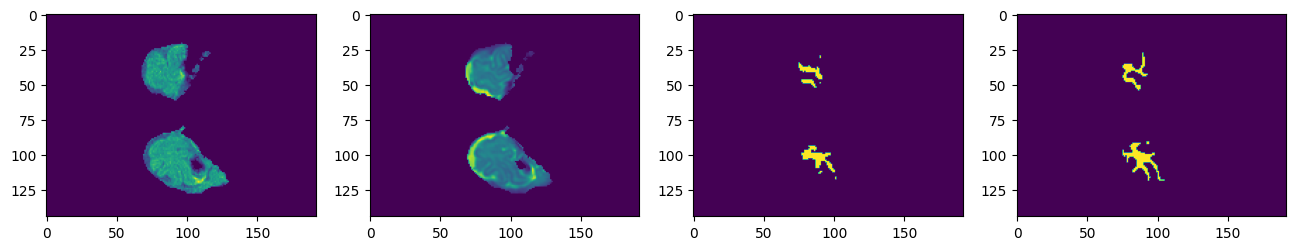

T1,T2, Prediction, Verite terrain


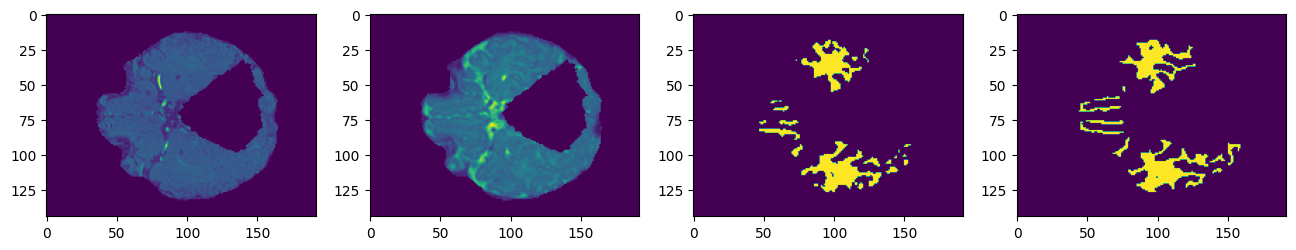

T1,T2, Prediction, Verite terrain


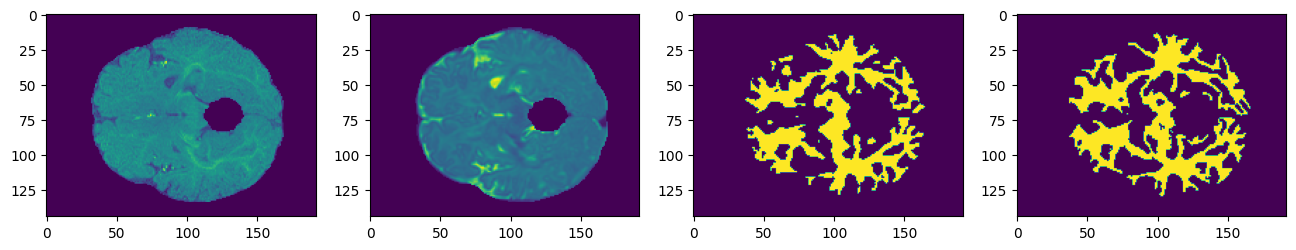

T1,T2, Prediction, Verite terrain


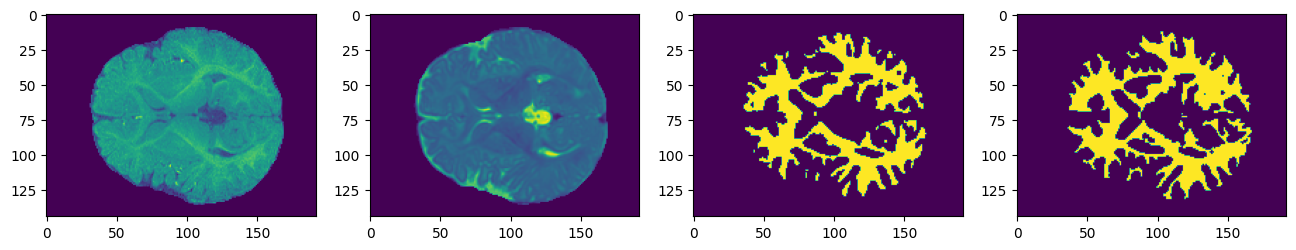

T1,T2, Prediction, Verite terrain


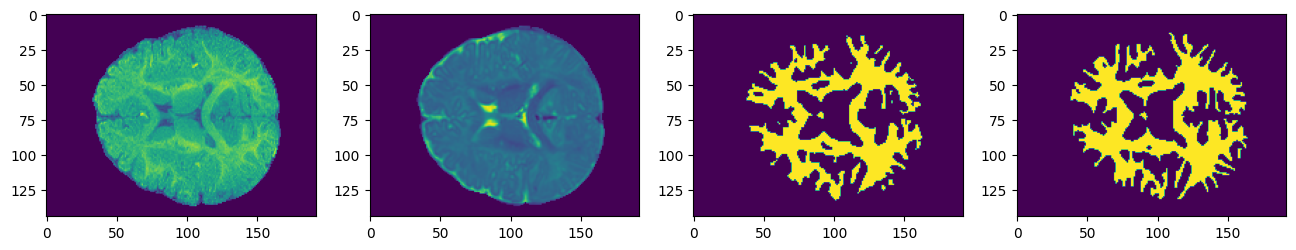

T1,T2, Prediction, Verite terrain


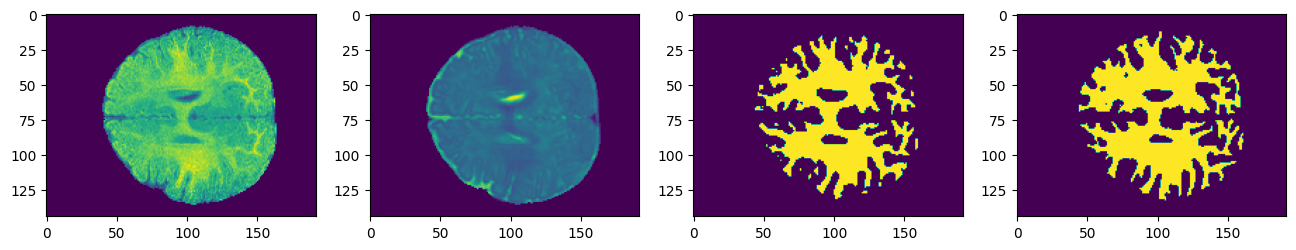

T1,T2, Prediction, Verite terrain


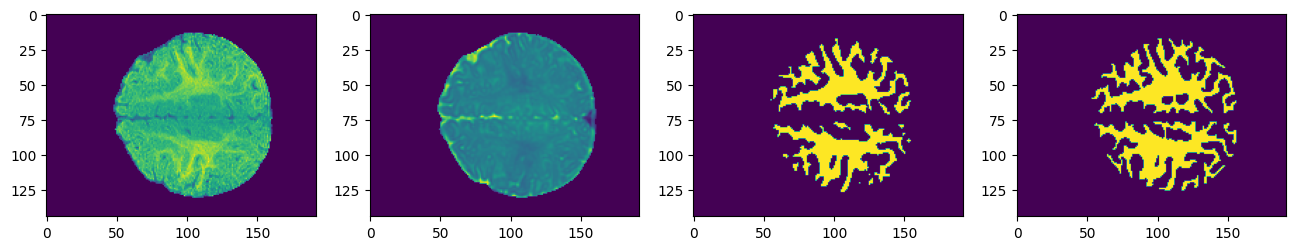

T1,T2, Prediction, Verite terrain


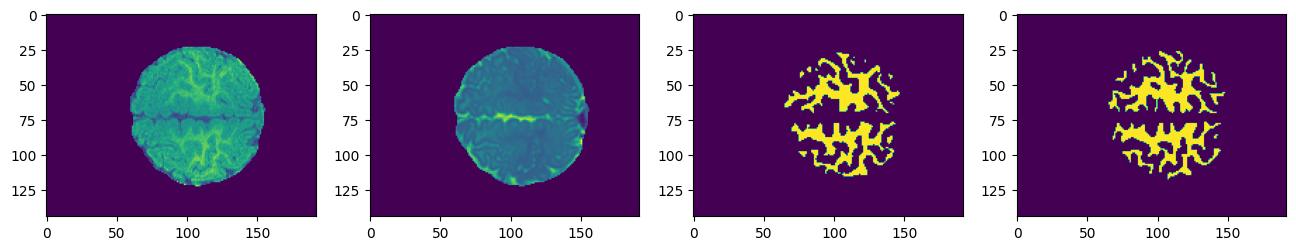

T1,T2, Prediction, Verite terrain


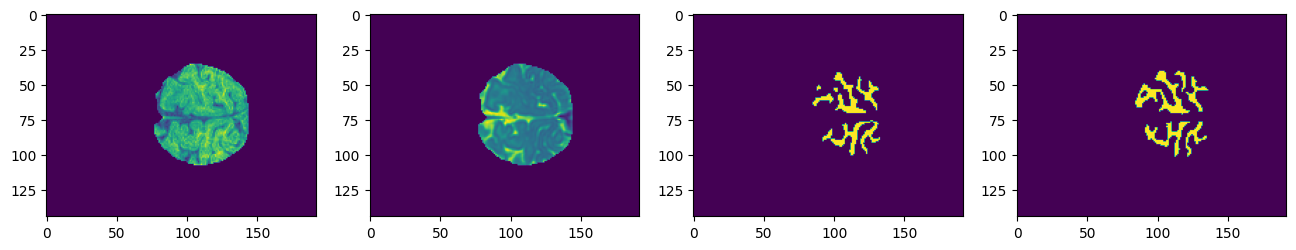

PATIENT (test):  subject-10-label.img
T1,T2, Prediction, Verite terrain


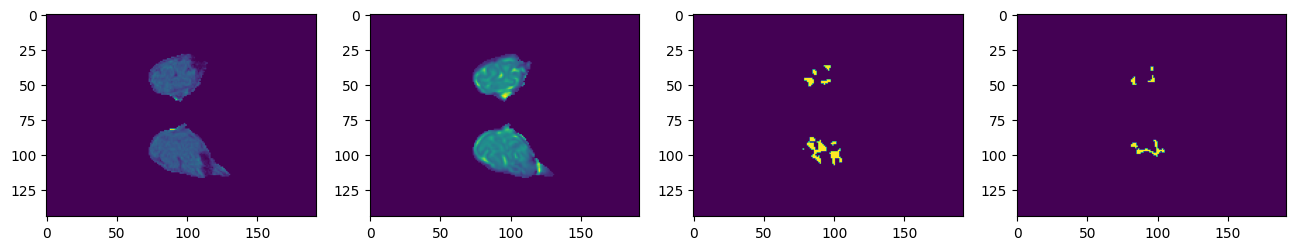

T1,T2, Prediction, Verite terrain


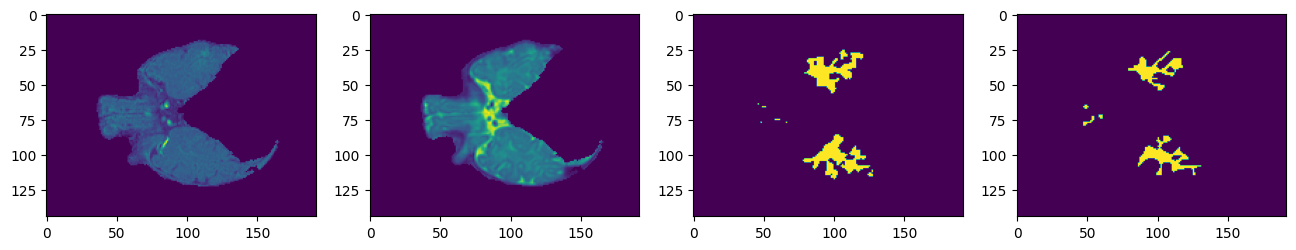

T1,T2, Prediction, Verite terrain


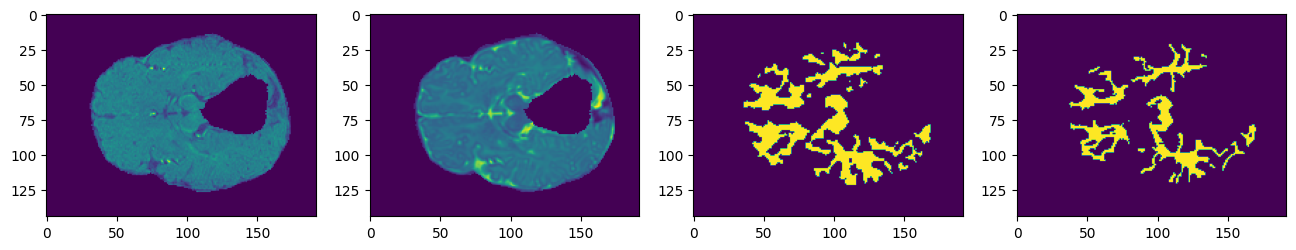

T1,T2, Prediction, Verite terrain


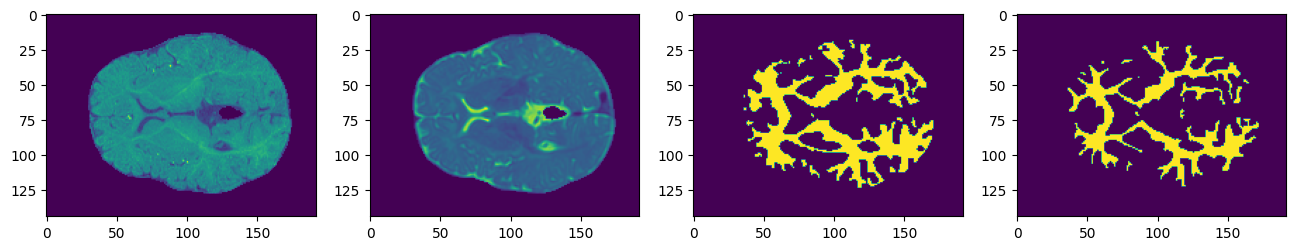

T1,T2, Prediction, Verite terrain


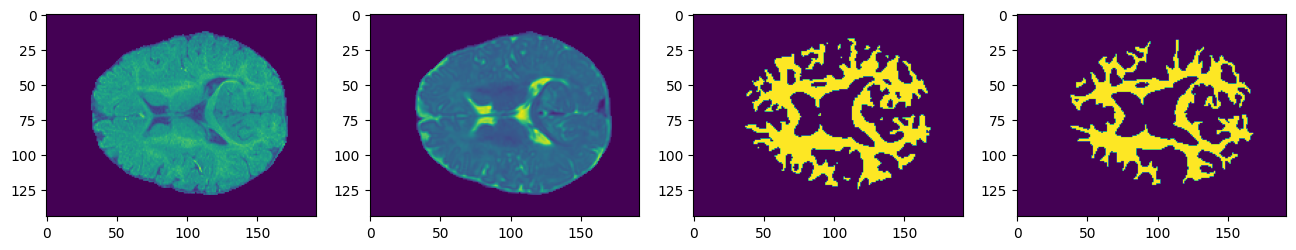

T1,T2, Prediction, Verite terrain


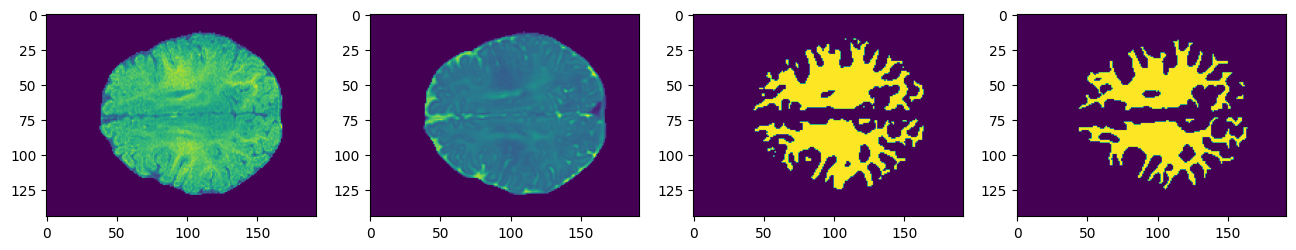

T1,T2, Prediction, Verite terrain


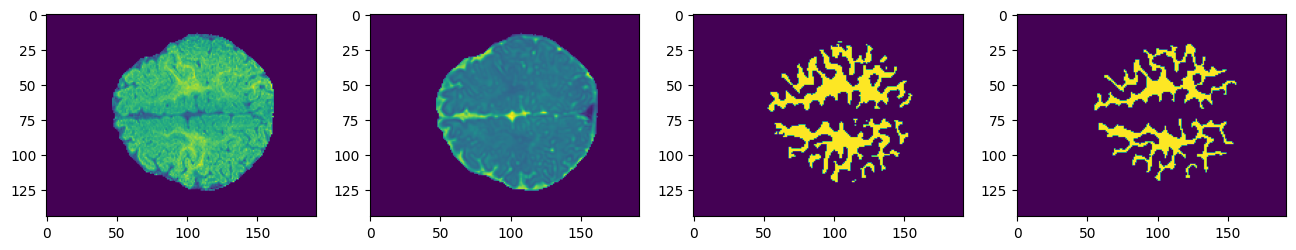

T1,T2, Prediction, Verite terrain


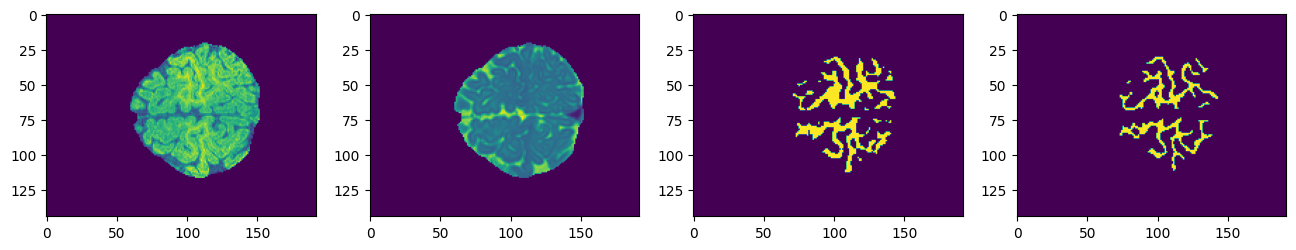

T1,T2, Prediction, Verite terrain


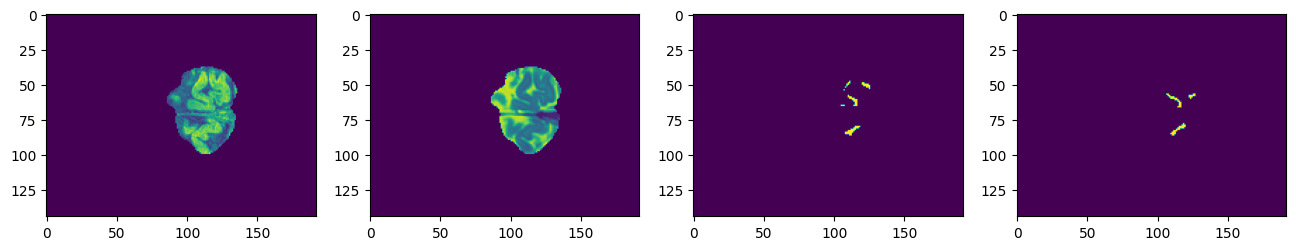

In [21]:
nb_patient = 1
num_patient_test = 0

liste_dices_matiere_grise = np.zeros((nb_patient_test,))

for dirname, _, filenames in os.walk(Dossier):
  for filename in filenames:
    if 'label' in filename and 'hdr' not in filename:
      if filename[:-10] in list_patient_test:
        print("PATIENT (test): ", filename)
        nomT1 = filename[:-10]+"-T1.img"
        T1 = nib.load(nomT1).get_fdata()
        nomT2 = filename[:-10]+"-T2.img"
        T2 = nib.load(nomT2).get_fdata()
        labels = nib.load(filename).get_fdata()

        sx, sy, sz, _ = labels.shape
        labels = np.array(labels).reshape((sx, sy, sz))

        prediction3D_250 = np.zeros((sx, sy, sz))

        T1normalise = Normalisation(T1).reshape((sx, sy, sz))
        T2normalise = Normalisation(T2).reshape((sx, sy, sz))
        VT10 = np.where(labels >= 10,1, 0).reshape((sx,sy,sz))
        VT150 = np.where(labels >= 150,1, 0).reshape((sx,sy,sz))
        VT250 = np.where(labels >= 250,1, 0).reshape((sx,sy,sz))

        for z in range(0, sz):
          inputreseau1 = np.zeros((1, sx, sy, 2))
          inputreseau1[0,:,:,0] = T1normalise[:,:,z]
          inputreseau1[0,:,:,1] = T2normalise[:,:,z]
          prediction10 = np.round(model_1.predict(inputreseau1, verbose=0).reshape((sx,sy)))

          inputreseau2 = np.zeros((1, sx, sy, 3))
          inputreseau2[0,:,:,0] = T1normalise[:,:,z]
          inputreseau2[0,:,:,1] = T2normalise[:,:,z]
          inputreseau2[0,:,:,2] = prediction10
          prediction150 = np.round(model_2.predict(inputreseau2, verbose=0).reshape((sx,sy)))

          inputreseau3 = np.zeros((1, sx, sy, 4))
          inputreseau3[0,:,:,0] = T1normalise[:,:,z]
          inputreseau3[0,:,:,1] = T2normalise[:,:,z]
          inputreseau3[0,:,:,2] = prediction10
          inputreseau3[0,:,:,3] = prediction150
          prediction250 = np.round(model_3.predict(inputreseau3, verbose=0).reshape((sx,sy)))
          prediction3D_250[:,:,z] = prediction250

          prediction_to_plot = np.copy(prediction250)
          VT_to_plot = np.copy(VT250[:,:,z])

          if z%10 == 0 and np.sum(VT_to_plot) > 0:
            VT_to_plot[0,0] = 1.0
            prediction_to_plot[0,0] = 1.0
            print("T1,T2, Prediction, Verite terrain")
            fast_display(T1normalise[:,:,z].reshape((sx,sy)), T2normalise[:,:,z].reshape((sx,sy)), prediction_to_plot[:,:].reshape((sx, sy)), VT_to_plot[:,:].reshape((sx,sy)))

        dice3 = compute_dice(prediction3D_250, VT250)
        liste_dices_matiere_grise[num_patient_test] = dice3
        num_patient_test += 1
      nb_patient += 1

In [24]:
print("dice unet 3 =", dice3)

dice unet 3 = 0.8536329234477585


# Etape finale

On regroupe les predictions binaires des 3 réseaux et on en déduit le fichier final par la formule :

prediction = 10 \* prediction10 + 140 \* prediction150 + 100 \* prediction250

PATIENT (test):  subject-9-label.img
T1,T2, Prediction, Verite terrain


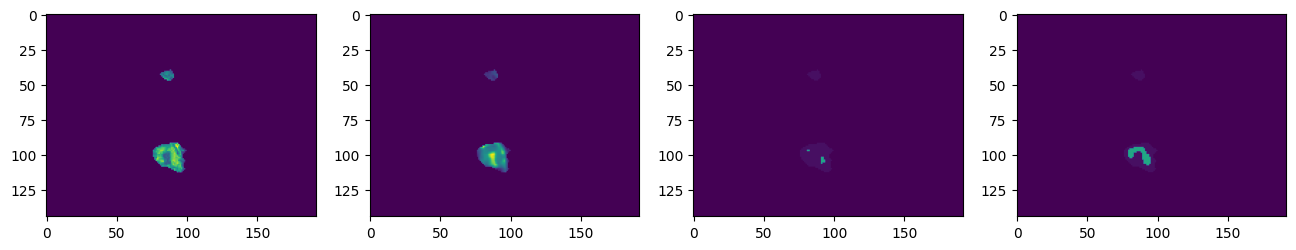

T1,T2, Prediction, Verite terrain


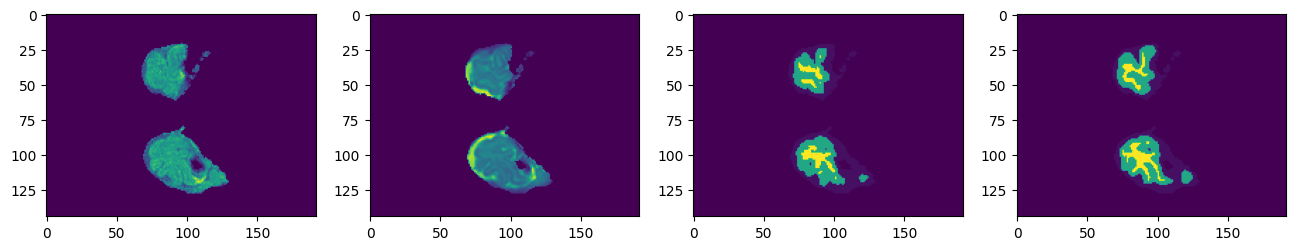

T1,T2, Prediction, Verite terrain


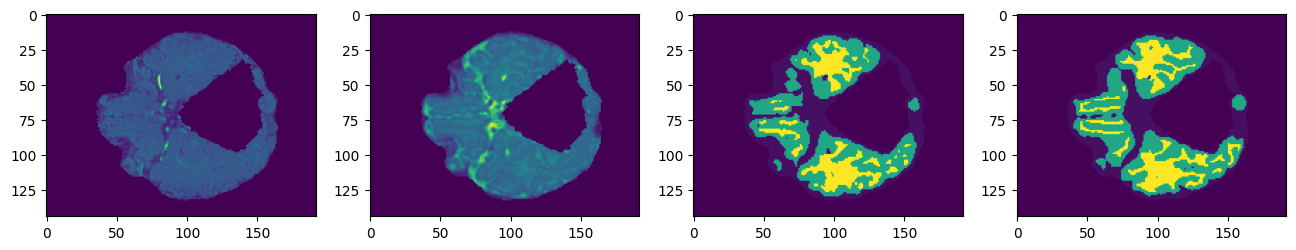

T1,T2, Prediction, Verite terrain


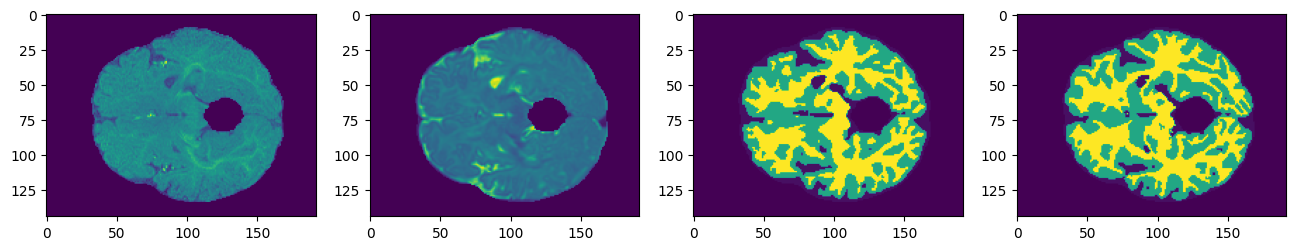

T1,T2, Prediction, Verite terrain


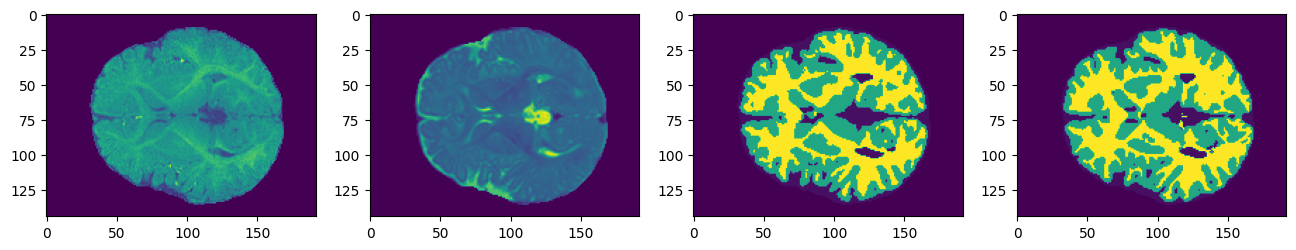

T1,T2, Prediction, Verite terrain


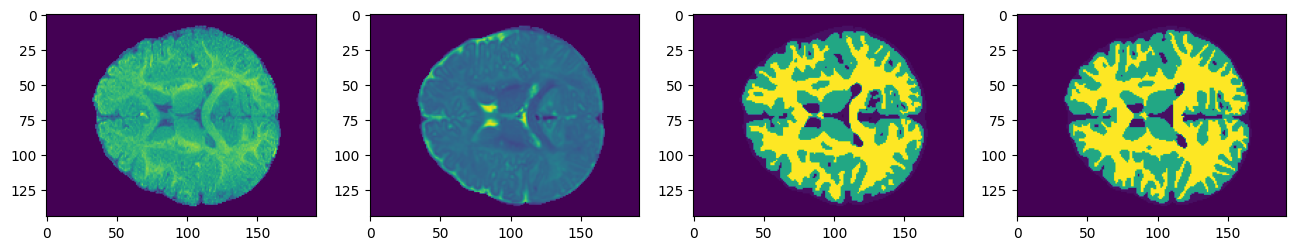

T1,T2, Prediction, Verite terrain


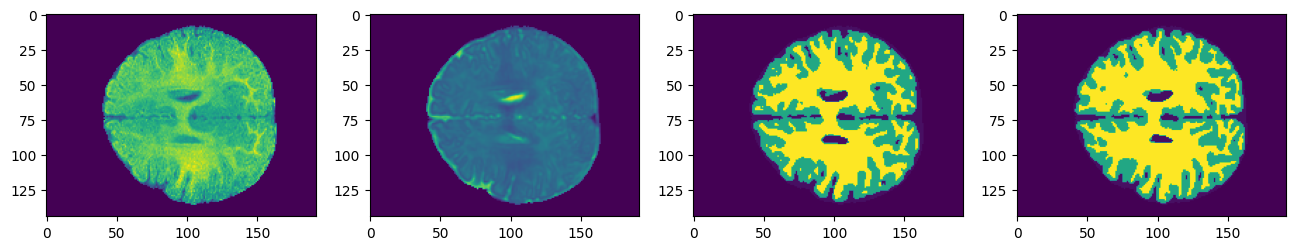

T1,T2, Prediction, Verite terrain


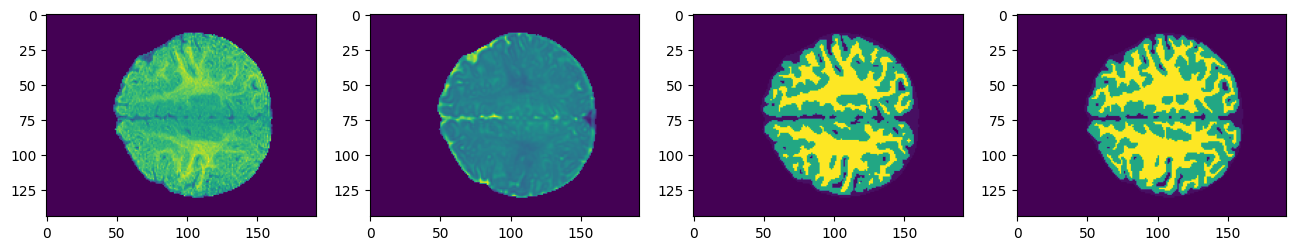

T1,T2, Prediction, Verite terrain


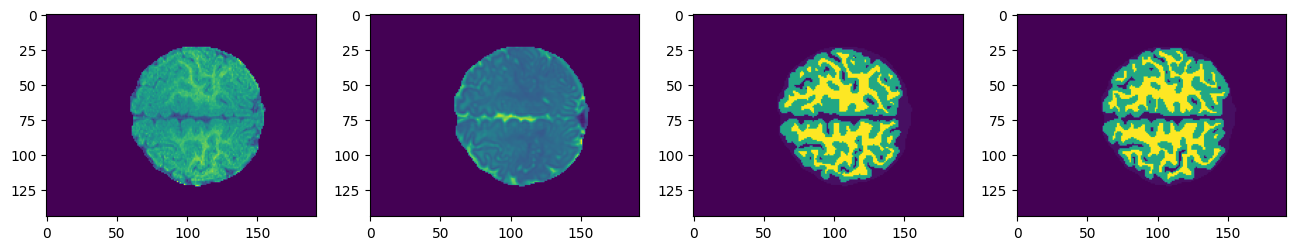

T1,T2, Prediction, Verite terrain


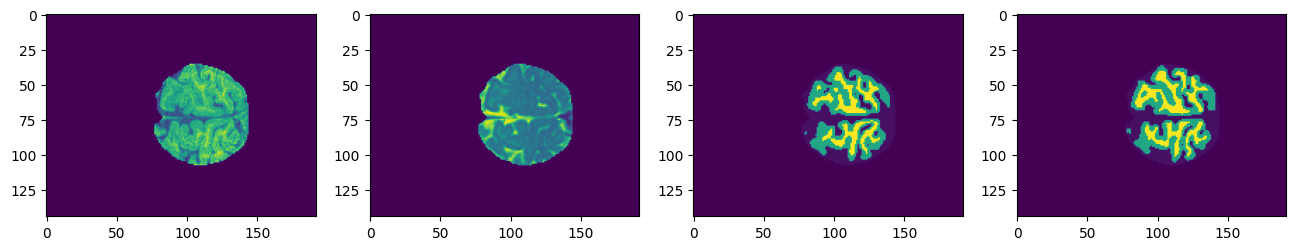

PATIENT (test):  subject-10-label.img
T1,T2, Prediction, Verite terrain


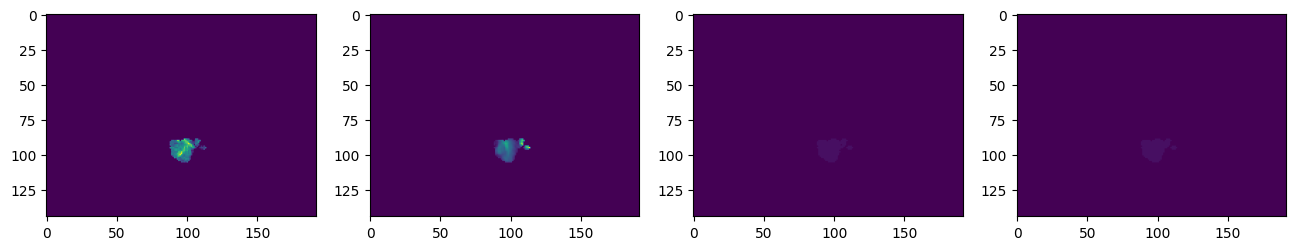

T1,T2, Prediction, Verite terrain


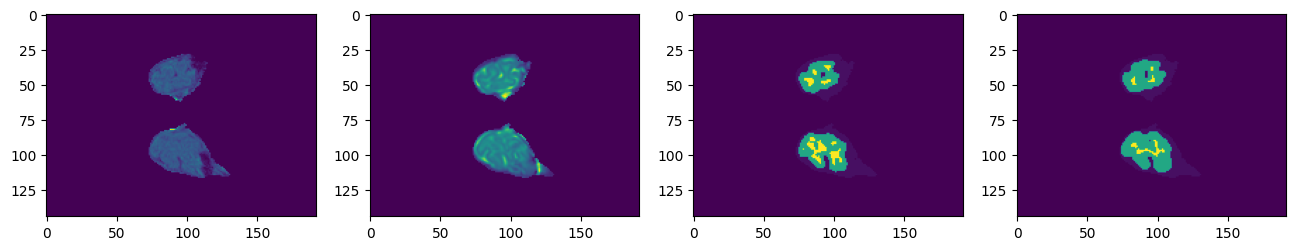

T1,T2, Prediction, Verite terrain


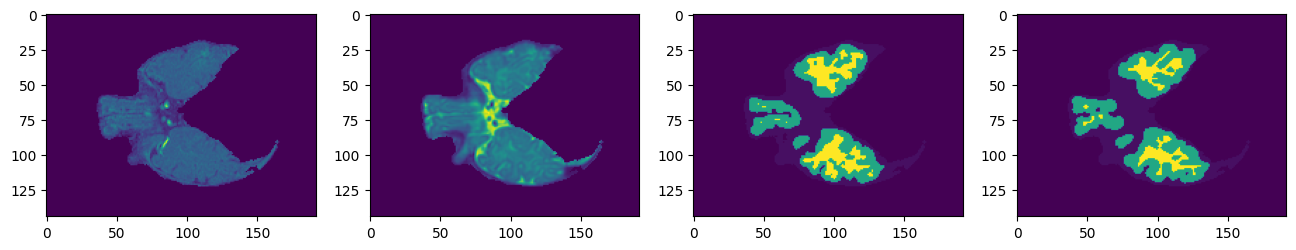

T1,T2, Prediction, Verite terrain


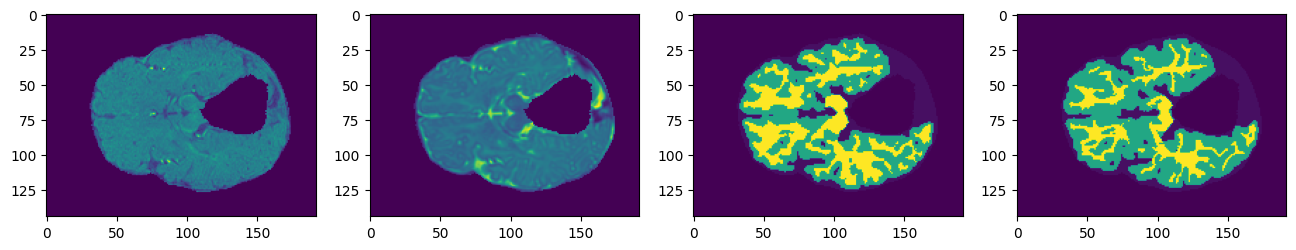

T1,T2, Prediction, Verite terrain


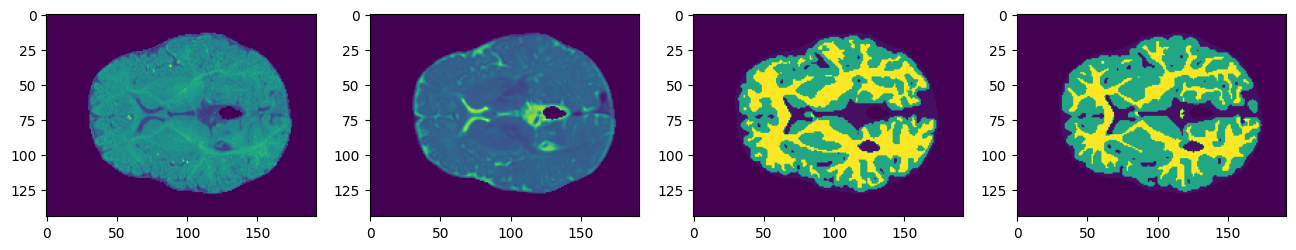

T1,T2, Prediction, Verite terrain


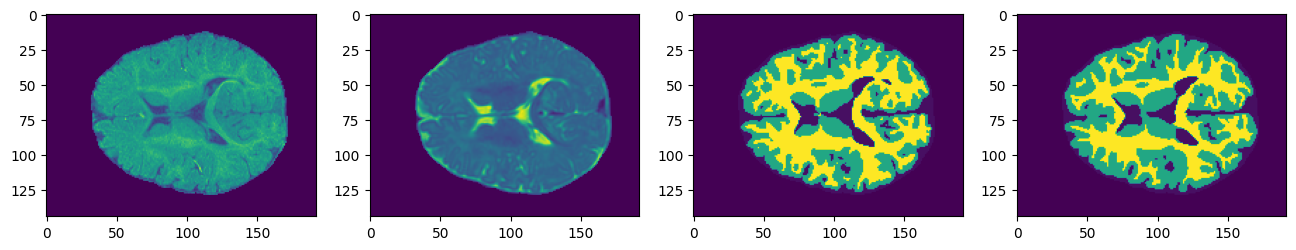

T1,T2, Prediction, Verite terrain


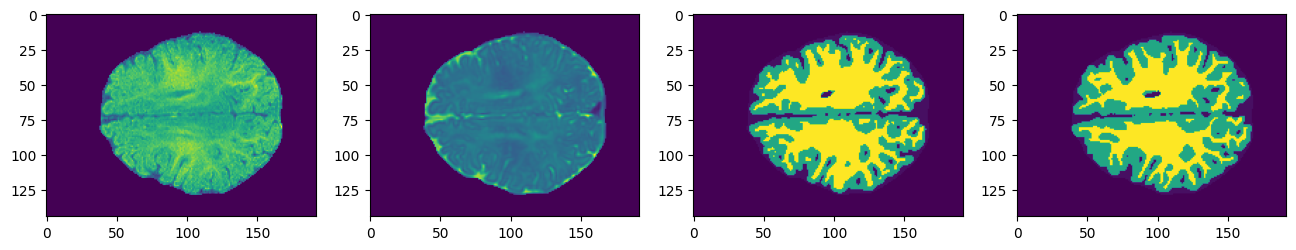

T1,T2, Prediction, Verite terrain


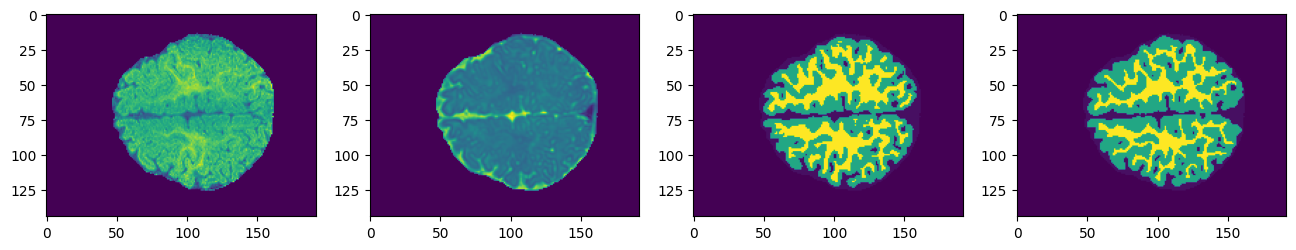

T1,T2, Prediction, Verite terrain


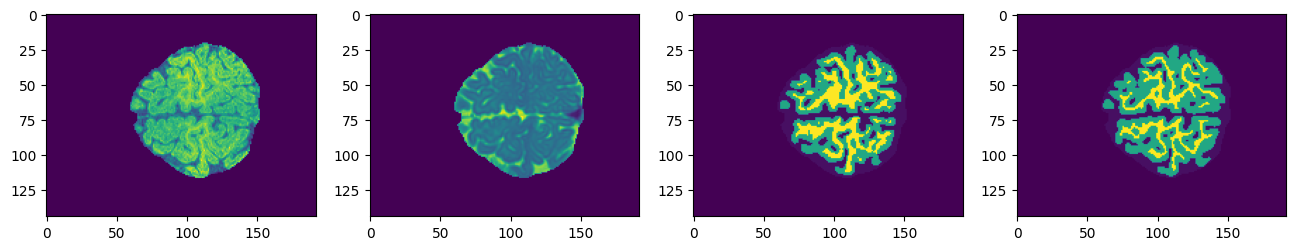

T1,T2, Prediction, Verite terrain


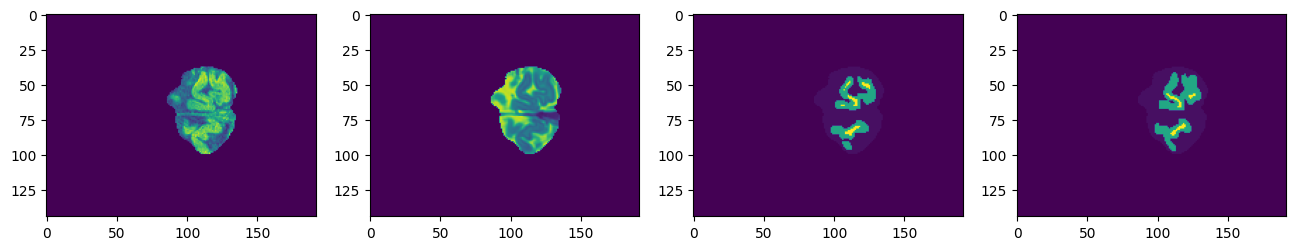

In [25]:
nb_patient = 1
num_patient_test = 0

for dirname, _, filenames in os.walk(Dossier):
  for filename in filenames:
    if 'label' in filename and 'hdr' not in filename:
      if filename[:-10] in list_patient_test:
        print("PATIENT (test): ", filename)
        nomT1 = filename[:-10]+"-T1.img"
        T1 = nib.load(nomT1).get_fdata()
        nomT2 = filename[:-10]+"-T2.img"
        T2 = nib.load(nomT2).get_fdata()
        labels = nib.load(filename).get_fdata()

        sx, sy, sz, _ = labels.shape
        labels = np.array(labels).reshape((sx, sy, sz))

        prediction3D_finale = np.zeros((sx, sy, sz))

        T1normalise = Normalisation(T1).reshape((sx, sy, sz))
        T2normalise = Normalisation(T2).reshape((sx, sy, sz))
        VT10 = np.where(labels >= 10,1, 0).reshape((sx,sy,sz))
        VT150 = np.where(labels >= 150,1, 0).reshape((sx,sy,sz))
        VT250 = np.where(labels >= 250,1, 0).reshape((sx,sy,sz))

        for z in range(0, sz):
          inputreseau1 = np.zeros((1, sx, sy, 2))
          inputreseau1[0,:,:,0] = T1normalise[:,:,z]
          inputreseau1[0,:,:,1] = T2normalise[:,:,z]

          prediction10 = np.round(model_1.predict(inputreseau1, verbose=0).reshape((sx,sy)))

          inputreseau2 = np.zeros((1, sx, sy, 3))
          inputreseau2[0,:,:,0] = T1normalise[:,:,z]
          inputreseau2[0,:,:,1] = T2normalise[:,:,z]
          inputreseau2[0,:,:,2] = prediction10
          prediction150 = np.round(model_2.predict(inputreseau2, verbose=0).reshape((sx,sy)))

          inputreseau3 = np.zeros((1, sx, sy, 4))
          inputreseau3[0,:,:,0] = T1normalise[:,:,z]
          inputreseau3[0,:,:,1] = T2normalise[:,:,z]
          inputreseau3[0,:,:,2] = prediction10
          inputreseau3[0,:,:,3] = prediction150
          prediction250 = np.round(model_3.predict(inputreseau3, verbose=0).reshape((sx,sy)))

          prediction3D_finale[:,:,z] = 10 * prediction10 + 140 * prediction150 + 100 * prediction250

          prediction_to_plot = np.copy(prediction3D_finale[:,:,z])
          VT_to_plot = np.copy(labels[:,:,z])

          if z%10 == 0 and np.sum(VT_to_plot) > 0:
            VT_to_plot[0,0] = 250
            prediction_to_plot[0,0] = 250
            print("T1,T2, Prediction, Verite terrain")
            fast_display(T1normalise[:,:,z].reshape((sx,sy)), T2normalise[:,:,z].reshape((sx,sy)), prediction_to_plot[:,:].reshape((sx, sy)), VT_to_plot[:,:].reshape((sx,sy)))

        dice = compute_dice(prediction3D_finale, VT250)
        num_patient_test += 1
      nb_patient += 1